In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
import ast
# import moss
import csv
import random
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from matplotlib.ticker import PercentFormatter
from statsmodels.stats.anova import AnovaRM
from sklearn.preprocessing import StandardScaler
from matplotlib.cm import get_cmap
from plot_utils import combined_rolling_average_and_model_fit, combined_sliding_window_and_model_fit_split_col
from common_functions import remove_unit_variance
from matplotlib.ticker import FuncFormatter, MultipleLocator


In [2]:
scaler = StandardScaler()

df = pd.read_csv('pilot_total.csv')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df_cleaned = pd.read_csv('pilot_total_errors.csv')


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_40215/45566082.py:3: DtypeWarning: Columns (254,255,256,257,258,259) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('pilot_total.csv')
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_40215/45566082.py:5: DtypeWarning: Columns (157,254,255,256,257,258,259) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv('pilot_total_errors.csv')


In [3]:
# df_cleaned['wm_untested_choice_num']

In [4]:
df['it_pos_neg'] =  np.where(df['it_sim_dis_diff_test'] <= 0, 0, 1)
df['v2_pos_neg'] =  np.where(df['v2_sim_dis_diff_test'] <= 0, 0, 1)
df_correct = df[df['resp_correct'] == 1]
#this approach here seems more correct
df_correct['wm_rt'] = df_correct['mouse.time_last'] * 1000
# df_correct['wm_rt'] = np.log(df_correct['wm_rt'])
df_correct = remove_unit_variance(df_correct,'wm_rt', 'participant')
df_correct['WM RT'] = df_correct['wm_rt']


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_40215/2543274082.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correct['wm_rt'] = df_correct['mouse.time_last'] * 1000


In [5]:
# !pip uninstall seaborn -y
# !pip install seaborn

In [6]:
sns.set_context('notebook')

In [7]:

blue = '#90BDEC'
gray = '#BFBFBF'

# Create a palette list
palette = [blue, gray]
sns.set_palette(palette)  # Set as default palette


In [8]:
df_cleaned['Error Category Accuracy'] = df_cleaned['wm_category_num']# use these for the errors - old ( if the errors are from the correct categories)
df_cleaned['Untested Item Error Accuracy'] = df_cleaned['wm_untested_choice_num'] # new errors 

df['Accuracy'] = df['resp_correct']
    

Total points: 80637, Window size: 16127, Step size: 1612
Total points: 60219, Window size: 12043, Step size: 1204
Total points: 17297, Window size: 3459, Step size: 345


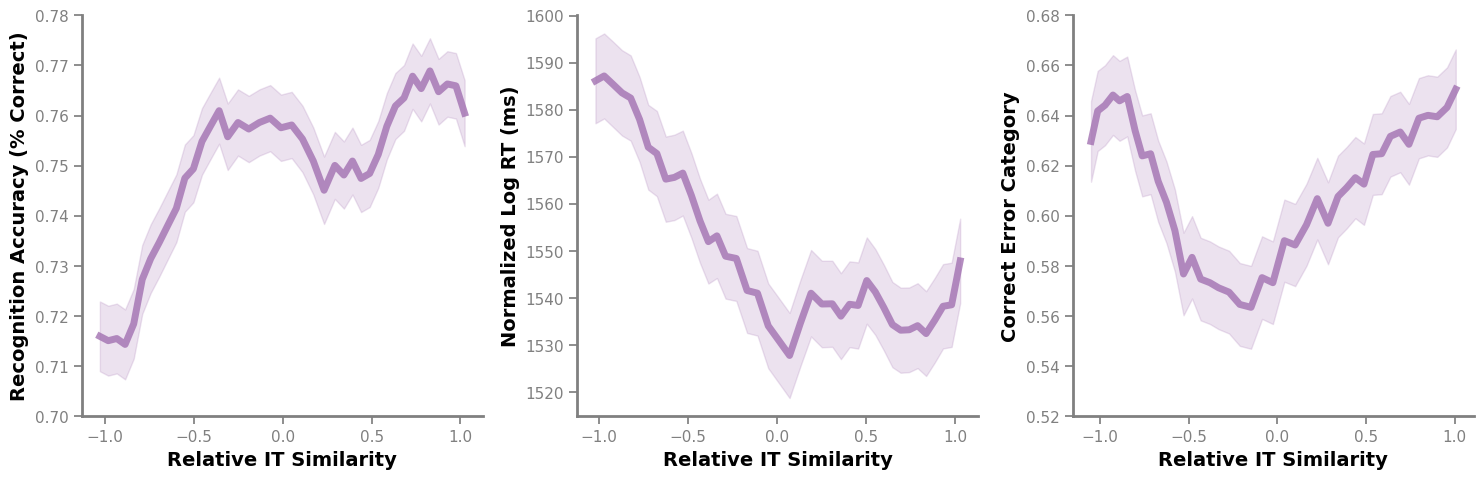

In [9]:

def combined_rolling_average_subplot(df, x_col="Tested - Untested IT Distractor Similarity", 
                                    y_col='Accuracy', item_col=None,
                                    window_percent=0.2, step_percent=0.01,
                                    palette=None, ax=None, show_title=True, show_xlabel=True):
    # Use provided axis or create new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 7))
        created_fig = True
    else:
        fig = ax.get_figure()
        created_fig = False
    
    # Set background colors
    if created_fig:
        fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Remove grid
    ax.grid(False)
    
    # Use provided palette or default
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
    # if palette is None:
    palette = [purple]
    
    # Color map for specific item types (using palette colors)
    color_map = {
        'prioritized': purple,
        'deprioritized': grey
    }
    
    # If splitting by item_col
    if item_col is not None and item_col in df.columns:
        # Get unique tested items
        tested_items = df[item_col].unique()
        
        # Plot rolling averages with labels
        for i, item in enumerate(tested_items):
            df_item = df[df[item_col] == item].sort_values(by=x_col).reset_index(drop=True)
            
            total_points = len(df_item)
            
            window_points = max(int(total_points * window_percent), 3)  # Ensure at least 3 points
            step_points = max(int(total_points * step_percent), 1)      # Ensure at least 1 point
            
            if total_points < window_points:
                print(f"Skipping {item} - insufficient data points ({total_points} < {window_points})")
                continue
                
            print(f"Item: {item}, Total points: {total_points}, Window size: {window_points}, Step size: {step_points}")
                
            x_values = []
            y_values = []
            y_errors = []
            
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_item.iloc[j:j+window_points]
                
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points)
                
                x_values.append(mean_x)
                y_values.append(mean_y)
                y_errors.append(sem_y)
            
            x_values = np.array(x_values)
            y_values = np.array(y_values)
            y_errors = np.array(y_errors)
            
            if len(x_values) == 0:
                continue
            
            # Select color based on item name or index in palette
            item_lower = str(item).lower()
            if item_lower in color_map:
                color = color_map[item_lower]
            elif 'prioritized' in item_lower:
                color = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                color = color_map['deprioritized']
            else:
                # Use palette color with modulo to ensure we don't go out of bounds
                color = palette[i % len(palette)]
            
            # Rolling average lines - now with labels and more visible
            ax.plot(x_values, y_values, color=color, linewidth=3, alpha=0.8, 
                   label=f'{item}')
            
            # Confidence bands
            ax.fill_between(x_values, 
                           y_values - 1.96 * y_errors,
                           y_values + 1.96 * y_errors,
                           color=color, alpha=0.2)
        
        title_suffix = f" by {item_col}"
    
    # If NOT splitting by item_col
    else:
        # Sort by x value
        df_sorted = df.sort_values(by=x_col).reset_index(drop=True)
        
        total_points = len(df_sorted)
        
        window_points = max(int(total_points * window_percent), 3)  # Ensure at least 3 points
        step_points = max(int(total_points * step_percent), 1)      # Ensure at least 1 point
        
        print(f"Total points: {total_points}, Window size: {window_points}, Step size: {step_points}")
            
        x_values = []
        y_values = []
        y_errors = []
        
        for j in range(0, total_points - window_points + 1, step_points):
            window = df_sorted.iloc[j:j+window_points]
            
            mean_x = window[x_col].mean()
            mean_y = window[y_col].mean()
            
            std_y = window[y_col].std()
            sem_y = std_y / np.sqrt(window_points)
            
            x_values.append(mean_x)
            y_values.append(mean_y)
            y_errors.append(sem_y)
        
        x_values = np.array(x_values)
        y_values = np.array(y_values)
        y_errors = np.array(y_errors)
        
        # Use first color from palette
        color = palette[0]
        
        # Rolling average line with label
        ax.plot(x_values, y_values, color=color, linewidth=5, alpha=0.8)
        
        # Confidence bands
        ax.fill_between(x_values, 
                       y_values - 1.96 * y_errors,
                       y_values + 1.96 * y_errors,
                       color=color, alpha=0.2)
                
        title_suffix = ""
    
    # Styling for axes and labels
    if show_xlabel:
        ax.set_xlabel(x_col, fontweight='bold', fontsize=14)
    else:
        ax.set_xlabel('')  # Remove x-axis label
    
    ax.set_ylabel(y_col, fontweight='bold', fontsize=14)
    
    # Don't create legend at subplot level when not standalone
    if created_fig:
        # Create legend and position it OUTSIDE the plot
        legend = ax.legend(frameon=True, fontsize=8, loc='center left', bbox_to_anchor=(1.0, 0.5))

    # Custom axis labels
    if x_col in ["Tested - Untested IT Distractor Similarity"]:
        ax.set_xlabel("Relative IT Similarity", fontweight='bold', fontsize=14)

    if x_col in ["Tested - Untested V2 Distractor Similarity"]:
        ax.set_xlabel("Relative V2 Similarity", fontweight='bold', fontsize=14)

    # Set y-axis limits if applicable
    if y_col.lower() in ['accuracy']:
        ax.set_ylabel("Recognition Accuracy (% Correct)", fontweight='bold', fontsize=14)

    if y_col.lower() in ['wm rt']:
        ax.set_ylabel("Normalized Log RT (ms)", fontweight='bold', fontsize=14)

    if y_col.lower() in ['error category accuracy']:
        ax.set_ylabel("Correct Error Category", fontweight='bold', fontsize=14)
    
    # Add spines with minimal styling - remove top and right borders
    ax.spines['left'].set_color('grey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params(axis='x', colors='grey')
    ax.tick_params(axis='y', colors='grey')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Only adjust layout if we created the figure
    if created_fig:
        plt.tight_layout()
        plt.subplots_adjust(right=0.8)  # Make room for the legend on the right
    
    return fig


# Example usage with different dataframes for each plot in a 3x1 grid
plot_configs = [
    {
        'df': df,  # Add dataframe to each config
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None
    },
    {
        'df': df_correct,  # Another dataframe
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None
    },
    {
        'df': df_cleaned,  # Another dataframe
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Error Category Accuracy",
        'item_col': None
    }
]

# Create the 3x1 grid
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Keep track of all handles and labels for the shared legend
all_handles = []
all_labels = []

for i, config in enumerate(plot_configs):
    combined_rolling_average_subplot(
        config['df'],  # Use the dataframe from config
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config['item_col'],
        window_percent=0.2,
        step_percent=0.02,
        palette=palette,
        ax=axes[i]
    )
    
    # Set y-axis limits for each subplot
    if i == 0: 
        axes[i].set_ylim(0.7, 0.78)
    # elif i == 1:  # RT plot
    #     axes[i].set_ylim(0.36, 0.42)
    elif i == 2:  # Error accuracy plot
        axes[i].set_ylim(0.52, 0.68)
    
    # Collect handles and labels from this subplot
    handles, labels = axes[i].get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in all_labels:  # Only add unique labels
            all_handles.append(handle)
            all_labels.append(label)

# Create one shared legend for the entire figure (only if there are legend items)
if all_handles and all_labels:
    fig.legend(all_handles, all_labels, loc='center', bbox_to_anchor=(0.5, 0.02), 
               ncol=len(all_labels), frameon=True, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the shared legend
plt.show()


In [10]:
# Use provided palette or default
grey = '#BFBFBF'
blue = '#6cbcef'
teal = '#49a791'
purple = '#a271b1'
salmon = '#e58a72'
gold = '#dbad40'
green = '#95c355'

Total points: 80637, Window size: 8063, Step size: 403
Total points: 60219, Window size: 6021, Step size: 301
Total points: 17297, Window size: 1729, Step size: 86


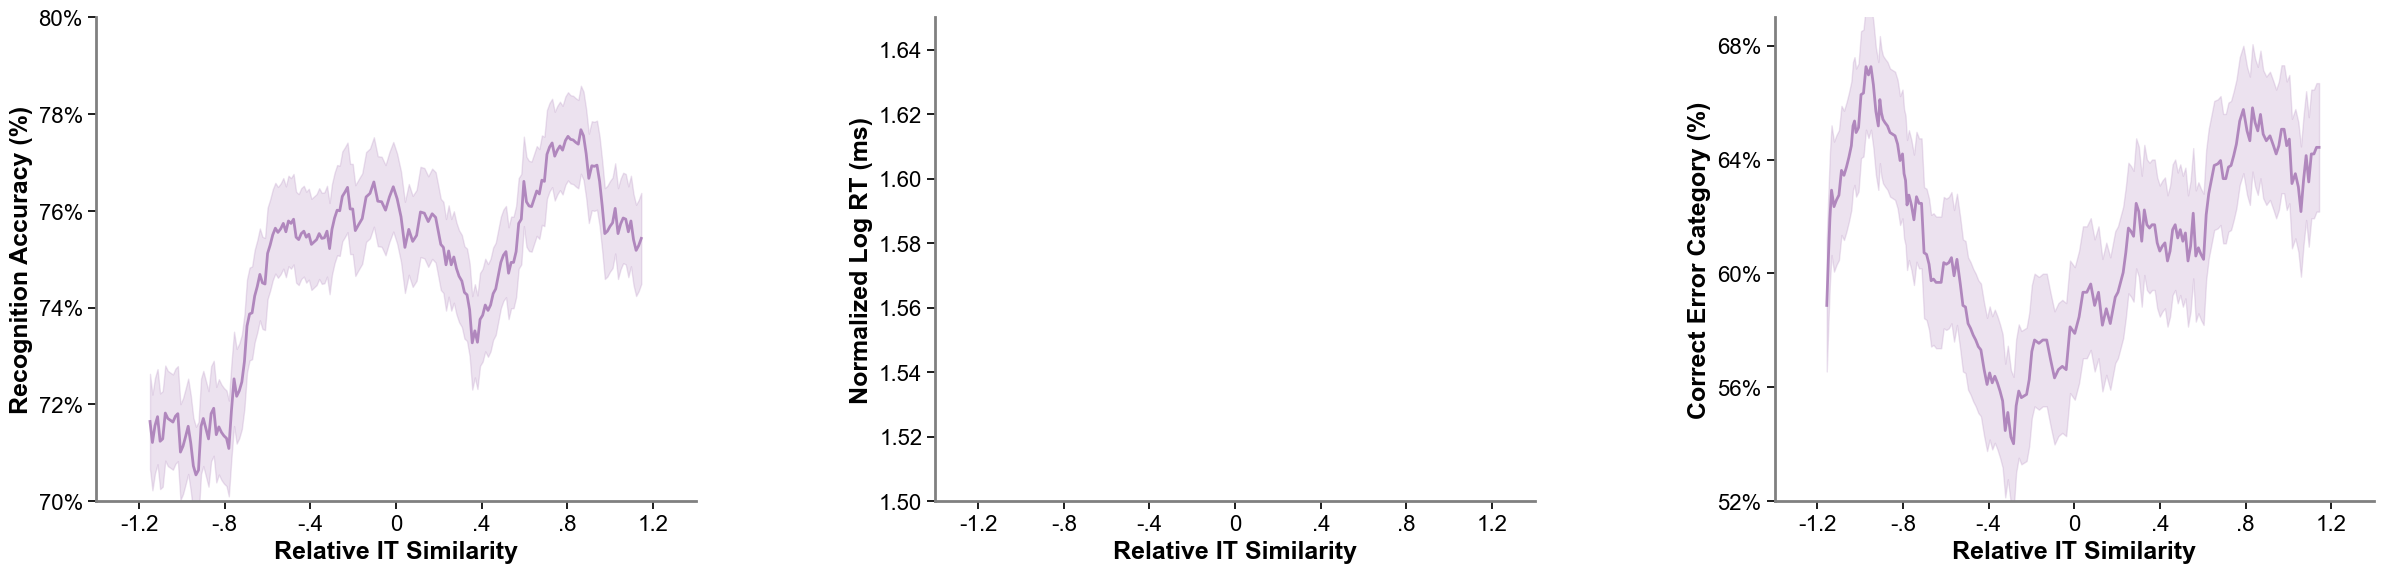

In [11]:

def remove_leading_zero_formatter(x, pos):
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def combined_rolling_average_subplot(df, x_col="Tested - Untested IT Distractor Similarity", 
                                    y_col='Accuracy', item_col=None,
                                    window_percent=0.2, step_percent=0.01,
                                    palette=None, ax=None, show_title=True, show_xlabel=True,
                                    
                                    # Font and color parameters
                                    font_family='Arial', 
                                    title_font_size=16, title_font_color='black', title_font_weight='bold',
                                    label_font_size=14, label_font_color='black', label_font_weight='bold',
                                    tick_font_size=12, tick_font_color='black',  # Changed from 'grey' to 'black'
                                    legend_font_size=10, legend_font_color='black',
                                    
                                    # Axis formatting parameters
                                    y_as_percentage=False, y_percentage_step=2, 
                                    x_tick_step=None, y_tick_step=None,
                                    x_limits=None, y_limits=None,
                                    x_ticks=None,  # NEW: explicit x-tick positions
                                    x_remove_leading_zero = True,
                                    # Spacing parameters
                                    line_width=2, confidence_alpha=0.2):
    """
    Enhanced rolling average subplot with customizable fonts, colors, and formatting.
    
    Parameters:
    -----------
    df : DataFrame
        Input data
    x_col, y_col : str
        Column names for x and y axes
    item_col : str, optional
        Column name for grouping items
    window_percent, step_percent : float
        Rolling window parameters
    palette : list, optional
        Color palette for lines
    ax : matplotlib axis, optional
        Axis to plot on
    show_title, show_xlabel : bool
        Whether to show title and x-label
    
    Font and color parameters:
    font_family : str
        Font family for all text
    title_font_size, label_font_size, tick_font_size, legend_font_size : int
        Font sizes for different elements
    title_font_color, label_font_color, tick_font_color, legend_font_color : str
        Font colors for different elements
    title_font_weight, label_font_weight : str
        Font weights ('normal', 'bold', etc.)
    
    Axis formatting parameters:
    y_as_percentage : bool
        Whether to format y-axis as percentages
    y_percentage_step : float
        Step size for percentage ticks (e.g., 2 for every 2%)
    x_tick_step, y_tick_step : float, optional
        Custom tick step sizes
    x_limits, y_limits : tuple, optional
        Custom axis limits (min, max)
    x_ticks : array-like, optional
        Explicit x-tick positions (overrides x_tick_step)
    
    Spacing parameters:
    line_width : float
        Width of the rolling average lines
    confidence_alpha : float
        Alpha value for confidence bands
    """
    
    # Use provided axis or create new one
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 7))
        created_fig = True
    else:
        fig = ax.get_figure()
        created_fig = False
    
    # Set background colors
    if created_fig:
        fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Remove grid
    ax.grid(False)
    
    # Use provided palette or default
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
    # Auto-select color based on x_col if no palette provided
    if palette is None:
        if "IT Distractor Similarity" in x_col:
            palette = [purple]
            color_map = {
                'prioritized': purple,
                'deprioritized': grey
            }
        elif "V2 Distractor Similarity" in x_col:
            palette = [teal]
            color_map = {
                        'prioritized': teal,
                        'deprioritized': grey
                    }
        else:
            palette = [purple]  # default
    
    # If splitting by item_col
    if item_col is not None and item_col in df.columns:
        # Get unique tested items
        tested_items = df[item_col].unique()
        
        # Plot rolling averages with labels
        for i, item in enumerate(tested_items):
            df_item = df[df[item_col] == item].sort_values(by=x_col).reset_index(drop=True)
            
            total_points = len(df_item)
            
            window_points = max(int(total_points * window_percent), 3)  # Ensure at least 3 points
            step_points = max(int(total_points * step_percent), 1)      # Ensure at least 1 point
            
            if total_points < window_points:
                print(f"Skipping {item} - insufficient data points ({total_points} < {window_points})")
                continue
                
            print(f"Item: {item}, Total points: {total_points}, Window size: {window_points}, Step size: {step_points}")
                
            x_values = []
            y_values = []
            y_errors = []
            
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_item.iloc[j:j+window_points]
                
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points)
                
                x_values.append(mean_x)
                y_values.append(mean_y)
                y_errors.append(sem_y)
            
            x_values = np.array(x_values)
            y_values = np.array(y_values)
            y_errors = np.array(y_errors)
            
            if len(x_values) == 0:
                continue
            
            # Select color based on item name or index in palette
            item_lower = str(item).lower()
            if item_lower in color_map:
                color = color_map[item_lower]
            elif 'prioritized' in item_lower:
                color = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                color = color_map['deprioritized']
            else:
                # Use palette color with modulo to ensure we don't go out of bounds
                color = palette[i % len(palette)]
            
            # Rolling average lines - now with customizable line width
            ax.plot(x_values, y_values, color=color, linewidth=line_width, alpha=0.8, 
                   label=f'{item}')
            
            # Confidence bands with customizable alpha
            ax.fill_between(x_values, 
                           y_values - 1.96 * y_errors,
                           y_values + 1.96 * y_errors,
                           color=color, alpha=confidence_alpha)
        
        title_suffix = f" by {item_col}"
    
    # If NOT splitting by item_col
    else:
        # Sort by x value
        df_sorted = df.sort_values(by=x_col).reset_index(drop=True)
        
        total_points = len(df_sorted)
        
        window_points = max(int(total_points * window_percent), 3)  # Ensure at least 3 points
        step_points = max(int(total_points * step_percent), 1)      # Ensure at least 1 point
        
        print(f"Total points: {total_points}, Window size: {window_points}, Step size: {step_points}")
            
        x_values = []
        y_values = []
        y_errors = []
        
        for j in range(0, total_points - window_points + 1, step_points):
            window = df_sorted.iloc[j:j+window_points]
            
            mean_x = window[x_col].mean()
            mean_y = window[y_col].mean()
            
            std_y = window[y_col].std()
            sem_y = std_y / np.sqrt(window_points)
            
            x_values.append(mean_x)
            y_values.append(mean_y)
            y_errors.append(sem_y)
        
        x_values = np.array(x_values)
        y_values = np.array(y_values)
        y_errors = np.array(y_errors)
        
        # Use first color from palette
        color = palette[0]
        
        # Rolling average line with customizable line width
        ax.plot(x_values, y_values, color=color, linewidth=line_width, alpha=0.8)
        
        # Confidence bands with customizable alpha
        ax.fill_between(x_values, 
                       y_values - 1.96 * y_errors,
                       y_values + 1.96 * y_errors,
                       color=color, alpha=confidence_alpha)
                
        title_suffix = ""
    
    # Styling for axes and labels with customizable fonts
    if show_xlabel:
        ax.set_xlabel(x_col, fontweight=label_font_weight, fontsize=label_font_size, 
                     color=label_font_color, fontfamily=font_family)
    else:
        ax.set_xlabel('')  # Remove x-axis label
    
    ax.set_ylabel(y_col, fontweight=label_font_weight, fontsize=label_font_size, 
                 color=label_font_color, fontfamily=font_family)
    
    # Custom axis labels with font styling
    if x_col in ["Tested - Untested IT Distractor Similarity"]:
        ax.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                     fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    if x_col in ["Tested - Untested V2 Distractor Similarity"]:
        ax.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                     fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    # Set y-axis labels and formatting
    if y_col.lower() in ['accuracy']:
        if y_as_percentage:
            ax.set_ylabel("Recognition Accuracy (%)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
            # Format y-axis as percentages and set custom ticks
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
            if y_tick_step is None:
                y_tick_step = y_percentage_step / 100.0  # Convert percentage to decimal
        else:
            ax.set_ylabel("Recognition Accuracy (% Correct)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    if y_col.lower() in ['wm rt']:
        ax.set_ylabel("Normalized Log RT (ms)", fontweight=label_font_weight, 
                     fontsize=label_font_size, color=label_font_color, fontfamily=font_family)

    if y_col.lower() in ['error category accuracy']:
        if y_as_percentage:
            ax.set_ylabel("Correct Error Category (%)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
            # Format y-axis as percentages and set custom ticks
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
            if y_tick_step is None:
                y_tick_step = y_percentage_step / 100.0  # Convert percentage to decimal
        else:
            ax.set_ylabel("Correct Error Category", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family)
    
    # Set custom x-axis ticks (NEW FEATURE)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    elif x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    
    # Set custom y-axis ticks
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))

    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Set custom axis limits
    if x_limits is not None:
        ax.set_xlim(x_limits)


    
    # Set custom axis limits
    if x_limits is not None:
        ax.set_xlim(x_limits)
    
    if y_limits is not None:
        ax.set_ylim(y_limits)
    
    # Style tick labels with custom fonts
    ax.tick_params(axis='x', colors=tick_font_color, labelsize=tick_font_size)
    ax.tick_params(axis='y', colors=tick_font_color, labelsize=tick_font_size)
    
    # Set font family for tick labels
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    # Don't create legend at subplot level when not standalone
    if created_fig:
        # Create legend with custom font styling
        legend = ax.legend(frameon=True, fontsize=legend_font_size, loc='center left', 
                          bbox_to_anchor=(1.0, 0.5))
        # Style legend text
        for text in legend.get_texts():
            text.set_fontfamily(font_family)
            text.set_color(legend_font_color)
    
    # Add spines with minimal styling - remove top and right borders
    ax.spines['left'].set_color('grey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_color('grey')
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Only adjust layout if we created the figure
    if created_fig:
        plt.tight_layout()
        plt.subplots_adjust(right=0.8)  # Make room for the legend on the right
    
    return fig


# Enhanced example usage with your specified x-axis settings
plot_configs = [
    {
        'df': df,  # Add dataframe to each config
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,  # Format as percentages
        'y_percentage_step': 2,   # Every 2%
        'y_limits': (0.7, 0.8), # Custom y-axis limits
        'x_limits': (-1.4, 1.4), # NEW: Your specified x-limits
        'x_tick_step': 0.4,      # NEW: Ticks every 0.2
        'font_family': 'Arial',
        'label_font_size': 18,    # Increased from 14
        'tick_font_size': 16      # Increased from 12
    },
    {
        'df': df_correct,  # Another dataframe
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None,
        'y_limits': (1.5, 1.65),
        'y_tick_step': 0.02,  # Custom y-axis step
        'x_limits': (-1.4, 1.4), # NEW: Your specified x-limits
        'x_tick_step': 0.4,      # NEW: Ticks every 0.2
        'font_family': 'Arial',
        'label_font_size': 18,    # Increased from 14
        'tick_font_size': 16      # Increased from 12
    },
    {
        'df': df_cleaned,  # Another dataframe
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Error Category Accuracy",
        'item_col': None,
        'y_as_percentage': True,  # Added percentage formatting
        'y_percentage_step': 4,   # Every 4% for this plot
        'y_limits': (0.52, 0.69),
        'y_tick_step': 0.04,  # Custom y-axis step
        'x_limits': (-1.4, 1.4), # NEW: Your specified x-limits
        'x_tick_step': 0.4,      # NEW: Ticks every 0.2
        'font_family': 'Arial',
        'label_font_size': 18,    # Increased from 14
        'tick_font_size': 16      # Increased from 12
    }
]

# Alternative: Using explicit x_ticks instead of x_tick_step
x_tick_positions = np.arange(-1.4, 1.6, 0.2)  # Creates [-1.4, -1.2, -1.0, ..., 1.2, 1.4]

plot_configs_alternative = [
    {
        'df': df,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'y_limits': (0.7, 0.8),
        'x_limits': (-1.4, 1.4),
        'x_tick_step': 0.4,      # NEW: Ticks every 0.2
        'font_family': 'Arial',
        'label_font_size': 18,
        'tick_font_size': 16
    },
    # ... (similar for other plots)
]

# Create the 3x1 grid with increased spacing
fig, axes = plt.subplots(1, 3, figsize=(24, 6))  # Increased figure width for more spacing
fig.subplots_adjust(wspace=0.4)  # Increase horizontal spacing between subplots

# Keep track of all handles and labels for the shared legend
all_handles = []
all_labels = []

for i, config in enumerate(plot_configs):
    combined_rolling_average_subplot(
        config['df'],  # Use the dataframe from config
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config['item_col'],
        window_percent=0.1,
        step_percent=0.005,
        ax=axes[i],
        
        # Pass the custom formatting options
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        y_limits=config.get('y_limits'),
        y_tick_step=config.get('y_tick_step'),
        x_limits=config.get('x_limits'),      # NEW: X-axis limits
        x_tick_step=config.get('x_tick_step'), # NEW: X-axis tick step
        x_ticks=config.get('x_ticks'),        # NEW: Explicit x-ticks

        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 18),
        tick_font_size=config.get('tick_font_size', 16)
    )
    
    # Collect handles and labels from this subplot
    handles, labels = axes[i].get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in all_labels:  # Only add unique labels
            all_handles.append(handle)
            all_labels.append(label)

# Create one shared legend for the entire figure (only if there are legend items)
if all_handles and all_labels:
    fig.legend(all_handles, all_labels, loc='center', bbox_to_anchor=(0.5, 0.02), 
               ncol=len(all_labels), frameon=True, fontsize=14)  # Increased legend font size

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, wspace=0.4)  # Make room for the shared legend and increase spacing
plt.show()

Total points: 80637, Window size: 8063, Step size: 1612
Total points: 60219, Window size: 6021, Step size: 1204
Total points: 17297, Window size: 1729, Step size: 345


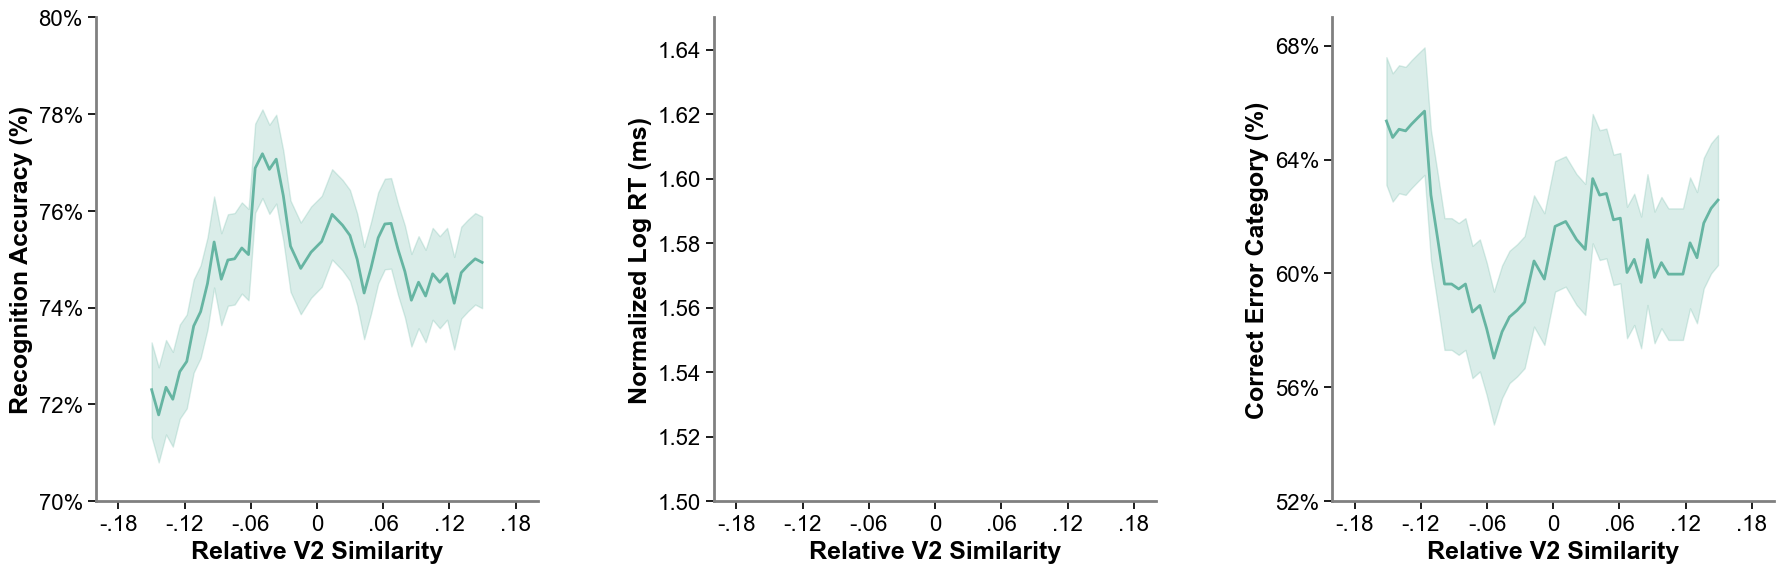

In [12]:
plot_configs = [
    {
        'df': df,  # Add dataframe to each config
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,  # Format as percentages
        'y_percentage_step': 2,   # Every 2%
        'y_limits': (0.7, 0.8), # Custom y-axis limits
        'x_limits': (-0.2, 0.2), # NEW: X-axis limits
        'x_tick_step': 0.06,     # NEW: Ticks every 0.04
        'font_family': 'Arial',
        'label_font_size': 18,
        'tick_font_size': 16
    },
    {
        'df': df_correct,  # Another dataframe
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None,
        'y_limits': (1.5, 1.65),
        'y_tick_step': 0.02,  # Custom y-axis step
        'x_limits': (-0.2, 0.2), # NEW: X-axis limits
        'x_tick_step': 0.06,     # NEW: Ticks every 0.04
        'font_family': 'Arial',
        'label_font_size': 18,
        'tick_font_size': 16
    },
    {
        'df': df_cleaned,  # Another dataframe
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "Error Category Accuracy",
        'item_col': None,
        'y_limits': (0.52, 0.69),
        'y_tick_step': 0.04,  # Custom y-axis step
        'y_as_percentage': True,  # Added percentage formatting
        'y_percentage_step': 4,   # Every 4% for this plot
        'x_limits': (-0.2, 0.2), # NEW: X-axis limits
        'x_tick_step': 0.06,     # NEW: Ticks every 0.04
        'font_family': 'Arial',
        'label_font_size': 18,
        'tick_font_size': 16
    }
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Increased figure width for more spacing
fig.subplots_adjust(wspace=0.4)  # Increase horizontal spacing between subplots

# Keep track of all handles and labels for the shared legend
all_handles = []
all_labels = []

for i, config in enumerate(plot_configs):
    combined_rolling_average_subplot(
        config['df'],  # Use the dataframe from config
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config['item_col'],
        window_percent=0.1,
        step_percent=0.02,
        ax=axes[i],
        
        # Pass the custom formatting options
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        y_limits=config.get('y_limits'),
        y_tick_step=config.get('y_tick_step'),
        x_limits=config.get('x_limits'),      # NEW: X-axis limits
        x_tick_step=config.get('x_tick_step'), # NEW: X-axis tick step
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 14),
        tick_font_size=config.get('tick_font_size', 12)
    )
    
    # Collect handles and labels from this subplot
    handles, labels = axes[i].get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in all_labels:  # Only add unique labels
            all_handles.append(handle)
            all_labels.append(label)

# Create one shared legend for the entire figure (only if there are legend items)
if all_handles and all_labels:
    fig.legend(all_handles, all_labels, loc='center', bbox_to_anchor=(0.5, 0.02), 
               ncol=len(all_labels), frameon=True, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, wspace=0.4)  # Make room for the shared legend and increase spacing
plt.show()

Item: prioritized, Total points: 60475, Window size: 12095, Step size: 1209
Item: deprioritized, Total points: 20162, Window size: 4032, Step size: 403
Item: prioritized, Total points: 46401, Window size: 9280, Step size: 928
Item: deprioritized, Total points: 13818, Window size: 2763, Step size: 276
Item: deprioritized, Total points: 5475, Window size: 1095, Step size: 109
Item: prioritized, Total points: 11822, Window size: 2364, Step size: 236


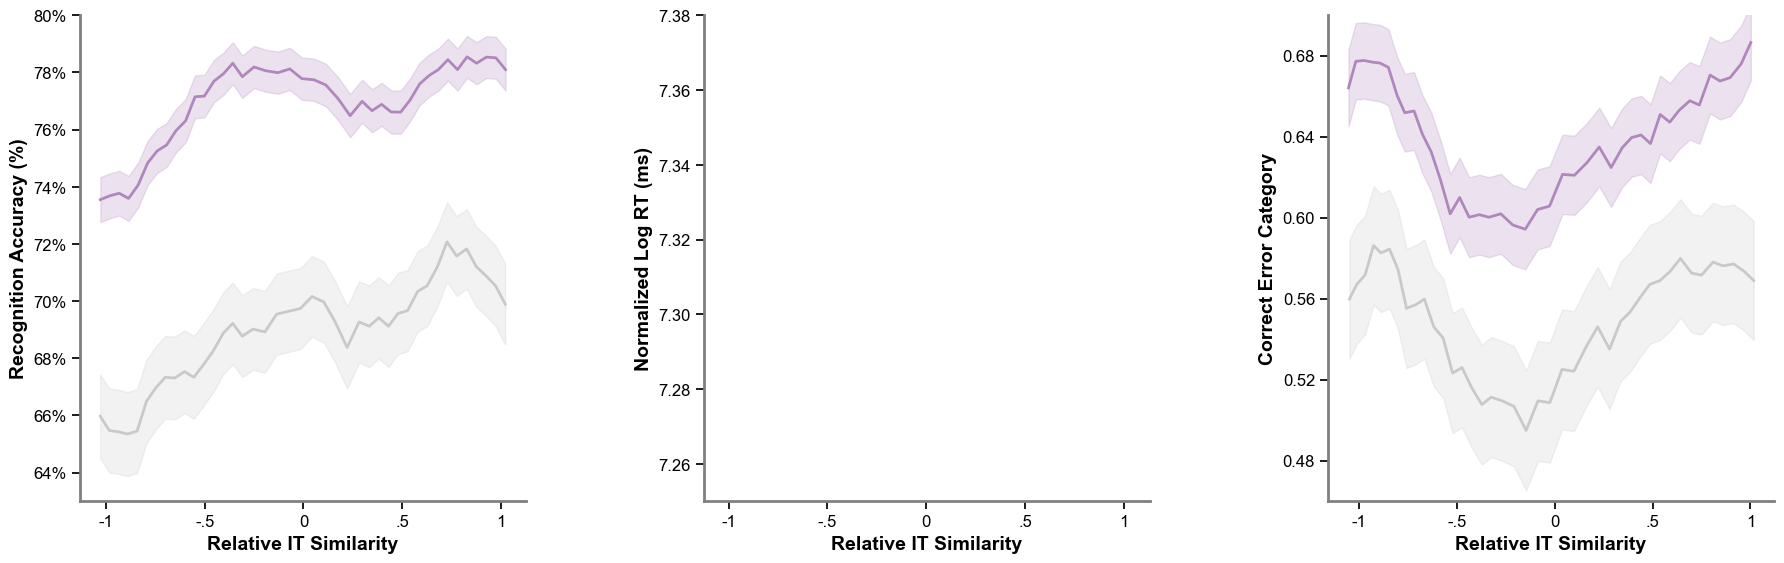

In [13]:

plot_configs = [
    {
        'df': df,  # Add dataframe to each config
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': 'Tested Item',
        'y_as_percentage': True,  # Format as percentages
        'y_percentage_step': 2,   # Every 2%
        'y_limits': (0.63, 0.8), # Custom y-axis limits
        'font_family': 'Arial',
        'label_font_size': 14,
        'tick_font_size': 12
    },
    {
        'df': df_correct,  # Another dataframe
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "WM RT",
        'item_col': 'Tested Item',
        'y_limits': (7.25, 7.38),
        'y_tick_step': 0.02,  # Custom y-axis step
        'font_family': 'Arial',
        'label_font_size': 14,
        'tick_font_size': 12
    },
    {
        'df': df_cleaned,  # Another dataframe
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Error Category Accuracy",
        'item_col': 'Tested Item',
        'y_limits': (0.46, 0.7),
        'y_tick_step': 0.04,  # Custom y-axis step
        'font_family': 'Arial',
        'label_font_size': 14,
        'tick_font_size': 12
    }
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Increased figure width for more spacing
fig.subplots_adjust(wspace=0.4)  # Increase horizontal spacing between subplots

# Keep track of all handles and labels for the shared legend
all_handles = []
all_labels = []

for i, config in enumerate(plot_configs):
    combined_rolling_average_subplot(
        config['df'],  # Use the dataframe from config
        x_col=config['x_col'],
        y_col=config['y_col'],
        item_col=config['item_col'],
        window_percent=0.2,
        step_percent=0.02,
        ax=axes[i],
        
        # Pass the custom formatting options
        y_as_percentage=config.get('y_as_percentage', False),
        y_percentage_step=config.get('y_percentage_step', 2),
        y_limits=config.get('y_limits'),
        y_tick_step=config.get('y_tick_step'),
        font_family=config.get('font_family', 'Arial'),
        label_font_size=config.get('label_font_size', 14),
        tick_font_size=config.get('tick_font_size', 12)
    )
    
    # Collect handles and labels from this subplot
    handles, labels = axes[i].get_legend_handles_labels()
    for handle, label in zip(handles, labels):
        if label not in all_labels:  # Only add unique labels
            all_handles.append(handle)
            # all_labels.append(label)

# Create one shared legend for the entire figure (only if there are legend items)
if all_handles and all_labels:
    fig.legend(all_handles, all_labels, loc='center', bbox_to_anchor=(0.5, 0.02), 
               ncol=len(all_labels), frameon=True, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, wspace=0.4)  # Make room for the shared legend and increase spacing
plt.show()

In [14]:

plot_configs_v2 = [
    {
        'df': df_correct,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None,
        'y_limits': (1500, 1620),
        'y_tick_step': 30,
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 1,
        'right_model_order': 2,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'y_limits': (0.7, 0.79),
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df_cleaned,
        'x_col': "Tested - Untested V2 Distractor Similarity",
        'y_col': "Error Category Accuracy",
        'item_col': None,
        'y_limits': (0.52, 0.69),
        'y_tick_step': 0.04,
        'y_as_percentage': True,
        'y_percentage_step': 4,
        'x_limits': (-0.16, 0.16),
        'x_tick_step': 0.04,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    }
]

plot_configs_it = [
    {
        'df': df_correct,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "WM RT",
        'item_col': None,
        'y_limits': (1500, 1620),
        'y_tick_step': 30,
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 2,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Accuracy",
        'item_col': None,
        'y_as_percentage': True,
        'y_percentage_step': 2,
        'y_limits': (0.7, 0.79),
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 3,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    },
    {
        'df': df_cleaned,
        'x_col': "Tested - Untested IT Distractor Similarity",
        'y_col': "Error Category Accuracy",
        'item_col': None,
        'y_limits': (0.52, 0.69),
        'y_tick_step': 0.04,
        'y_as_percentage': True,
        'y_percentage_step': 4,
        'x_limits': (-1.3, 1.3),
        'x_tick_step': 0.4,
        'window_percent': 0.2,
        'step_percent': 0.02,
        'left_model_order': 3,
        'right_model_order': 1,
        'trim_percentile': 0,
        'font_family': 'Arial',
        'label_font_size': 28,
        'tick_font_size': 26
    }
]

slightly increasing the width of the continuous plot so that it has a more similar aspect ratio to the split plots
slightly increasing the height of all of them
fixing the y-axis labels to match those we use for Fig. 1

left side - All Data, Total points: 29907, Window size: 5981, Step size: 598
  📊 left side - All Data Model Fit Exclusions:
     Total points: 29907
     No trimming applied
     Excluded by rolling constraint - Left edge: 2938
     Excluded by rolling constraint - Right edge: 2986
     Points used in model fit: 23983
     Total excluded: 5924
Total points: 60219, Window size: 6021, Step size: 602
right side - All Data, Total points: 30312, Window size: 6062, Step size: 606
  📊 right side - All Data Model Fit Exclusions:
     Total points: 30312
     No trimming applied
     Excluded by rolling constraint - Left edge: 2988
     Excluded by rolling constraint - Right edge: 3002
     Points used in model fit: 24322
     Total excluded: 5990
left side - All Data, Total points: 40584, Window size: 8116, Step size: 811
  📊 left side - All Data Model Fit Exclusions:
     Total points: 40584
     No trimming applied
     Excluded by rolling constraint - Left edge: 4001
     Excluded by rollin

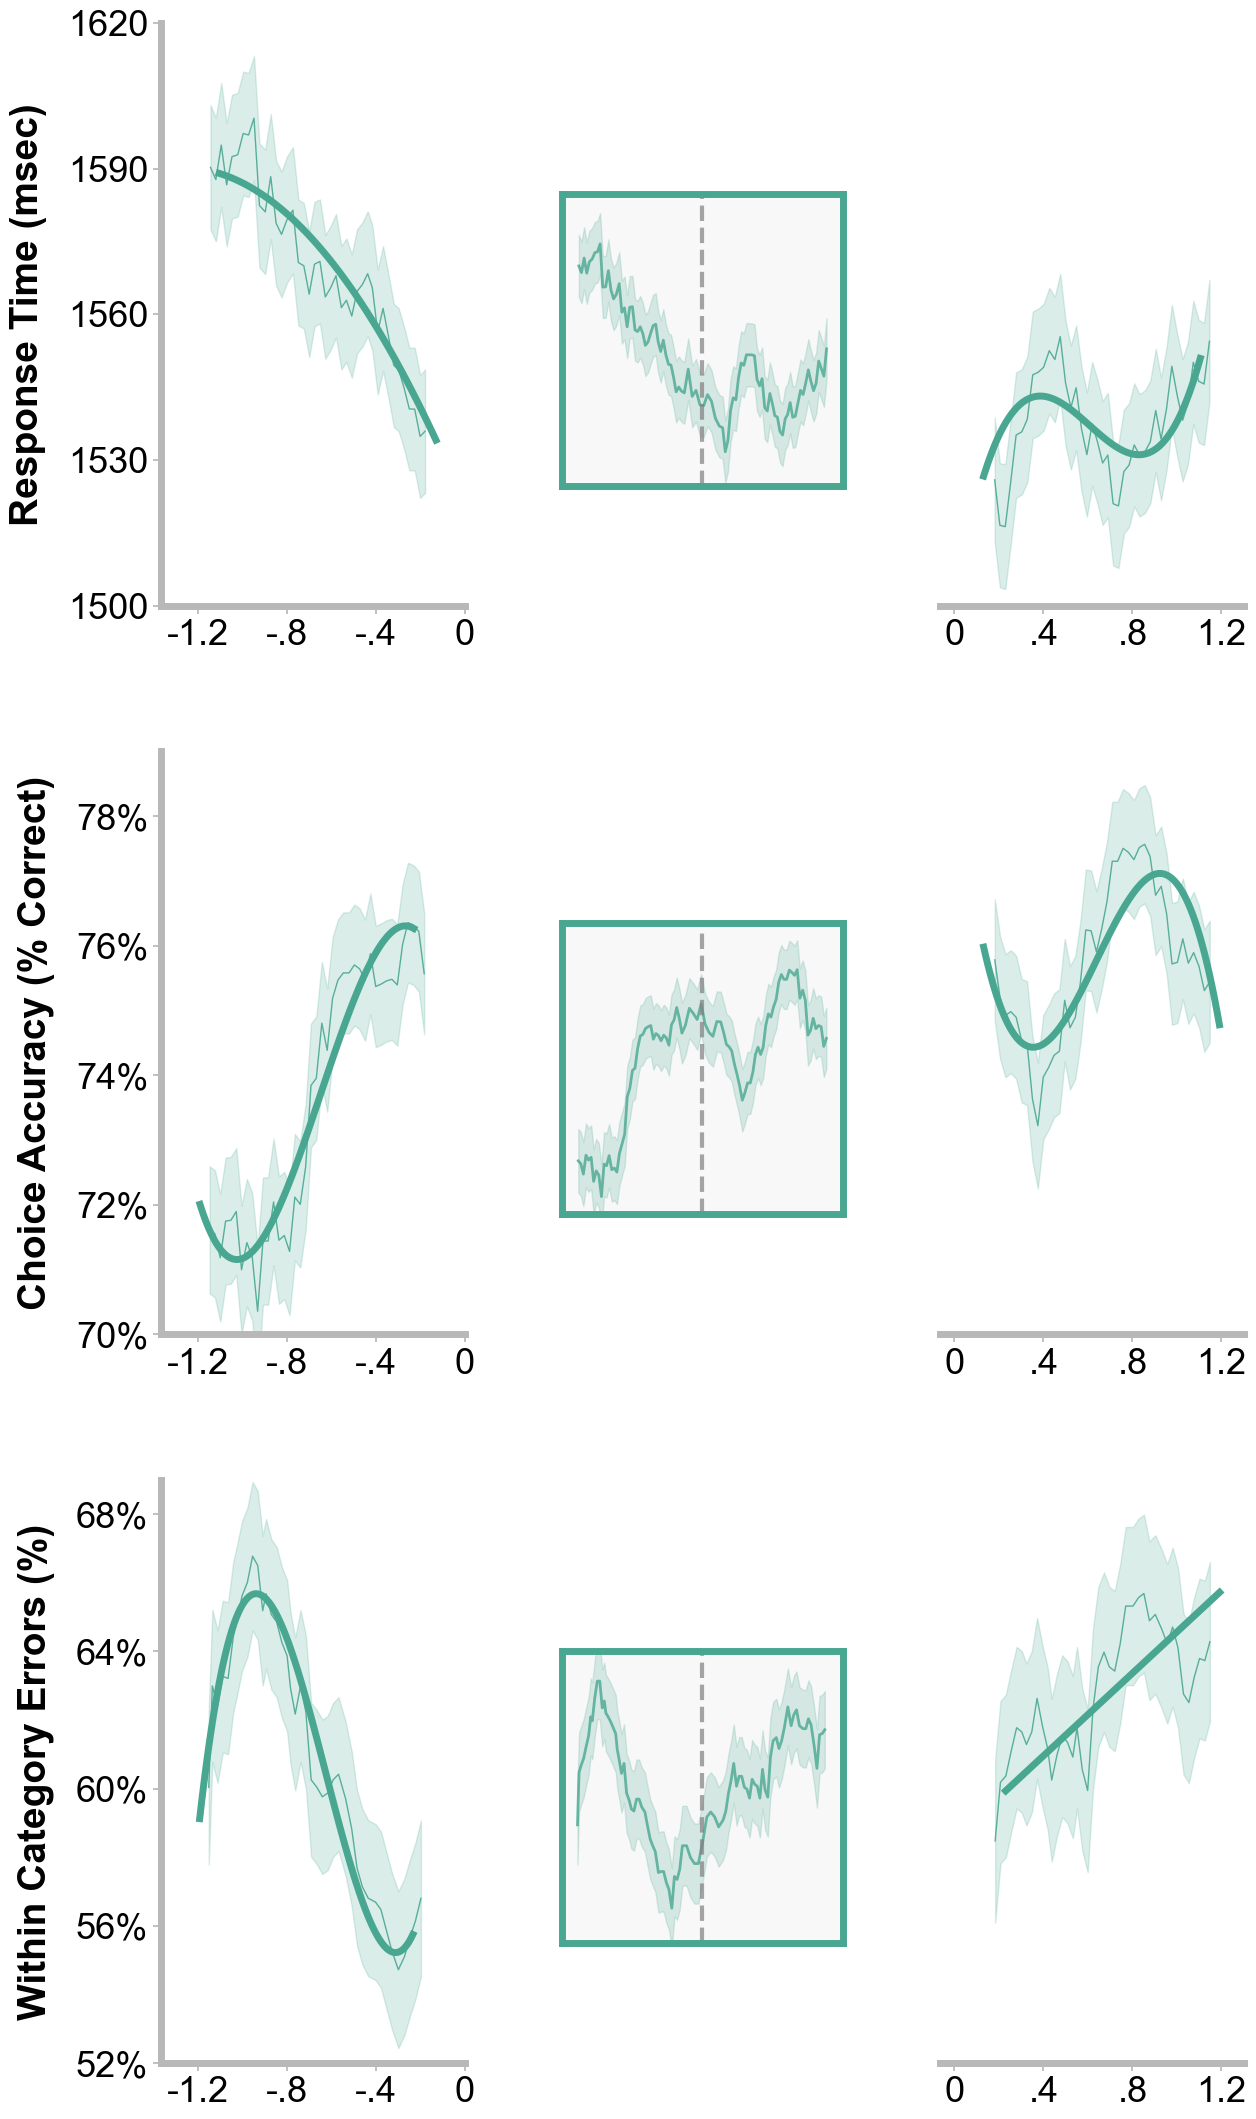

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
from matplotlib.ticker import FuncFormatter, MultipleLocator

def remove_leading_zero_formatter(x, pos):
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def create_continuous_rolling_plot(df, x_col, y_col, item_col=None, 
                                 window_percent=0.1, step_percent=0.02,
                                 ax=None, 
                                 y_limits=None, x_limits=None,
                                 x_tick_step=None, y_tick_step=None, x_ticks=None,
                                 y_as_percentage=False, y_percentage_step=2,
                                 font_family='Arial',
                                 title_font_size=18, title_font_color='black', title_font_weight='bold',
                                 label_font_size=16, label_font_color='black', label_font_weight='bold',
                                 tick_font_size=14, tick_font_color='black',
                                 line_width=3, confidence_alpha=0.2,
                                 show_title=True):
    
    if "IT Distractor Similarity" in x_col:
        palette = ['#49a791']
    elif "V2 Distractor Similarity" in x_col:
        palette = ['#95c355']
    else:
        palette = ['#49a791']
    
    fig = combined_rolling_average_subplot(
        df=df, 
        x_col=x_col, 
        y_col=y_col, 
        item_col=item_col,
        window_percent=window_percent, 
        step_percent=step_percent,
        palette=palette,
        ax=ax, 
        show_title=False,
        show_xlabel=True,
        font_family=font_family, 
        title_font_size=title_font_size, 
        title_font_color=title_font_color, 
        title_font_weight=title_font_weight,
        label_font_size=label_font_size, 
        label_font_color=label_font_color, 
        label_font_weight=label_font_weight,
        tick_font_size=tick_font_size-2,
        tick_font_color=tick_font_color,
        y_as_percentage=y_as_percentage, 
        y_percentage_step=y_percentage_step, 
        x_tick_step=x_tick_step, 
        y_tick_step=y_tick_step,
        x_limits=x_limits, 
        y_limits=y_limits,
        x_ticks=x_ticks,
        line_width=line_width, 
        confidence_alpha=confidence_alpha
    )
    
    ax.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=3)
    
    if show_title:
        ax.set_title("Continuous", fontsize=title_font_size-2, 
                    color=title_font_color, fontweight=title_font_weight, 
                    fontfamily=font_family, pad=15)
    
    ax.set_xlabel('')
    ax.tick_params(axis='x', bottom=False, labelbottom=False)
    ax.spines['bottom'].set_visible(False)
    
    return ax


def create_single_side_plot(df, x_col, y_col, item_col=None, 
                           split_col='v2_pos_neg', split_value=0, side='left',
                           window_percent=0.2, step_percent=0.02,
                           ax=None, palette=None,
                           y_limits=None, x_limits=None,
                           x_tick_step=None, y_tick_step=None,
                           model_order=2, trim_percentile=0,
                           y_as_percentage=False, y_percentage_step=2,
                           x_buffer_percent=0.05,
                           font_family='Arial',
                           title_font_size=18, title_font_color='black', title_font_weight='bold',
                           label_font_size=16, label_font_color='black', label_font_weight='bold',
                           tick_font_size=14, tick_font_color='black',
                           rolling_line_width=1, model_line_width=5,
                           confidence_alpha=0.2, rolling_alpha=0.9,
                           show_title=True, show_ylabel=True, show_xlabel=True,
                           grey_out_model=False,
                           # NEW PARAMETERS FOR MODEL FIT EXTRACTION
                           save_model_fits=False, model_fits_storage=None):
    
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
    if palette is None:
        if "IT Distractor Similarity" in x_col:
            default_colors = [teal, grey]
        elif "V2 Distractor Similarity" in x_col:
            default_colors = [green, grey]
        else:
            default_colors = [teal, grey]
    else:
        default_colors = palette
    
    color_map = {
        'prioritized': default_colors[0],    
        'deprioritized': default_colors[1] if len(default_colors) > 1 else grey,  
    }
    
    if side == 'left':
        df_side = df[df[x_col] <= split_value].copy()
        title_text = f"{x_col} ≤ {split_value}"
    else:
        df_side = df[df[x_col] > split_value].copy()
        title_text = f"{x_col} > {split_value}"
    
    ax.set_facecolor('white')
    
    item_color_dict = {}
    if item_col is not None and item_col in df.columns:
        all_items = df[item_col].unique()
        for i, item in enumerate(all_items):
            item_lower = str(item).lower()
            if item_lower in color_map:
                item_color_dict[item] = color_map[item_lower]
            elif 'prioritized' in item_lower:
                item_color_dict[item] = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                item_color_dict[item] = color_map['deprioritized']
            else:
                item_color_dict[item] = default_colors[i % len(default_colors)]
    
    # Initialize model fits storage for this side if saving is enabled
    if save_model_fits and model_fits_storage is not None:
        side_key = f"{side}_side"
        if side_key not in model_fits_storage:
            model_fits_storage[side_key] = {}
    
    if item_col is not None and item_col in df.columns:
        items = df_side[item_col].unique()
        
        for i, item in enumerate(items):
            df_item = df_side[df_side[item_col] == item].copy()
            df_item = df_item.sort_values(by=x_col).reset_index(drop=True)
            total_points = len(df_item)
            
            window_points = max(int(total_points * window_percent), 3)
            step_points = max(int(total_points * step_percent), 1)
            color = item_color_dict.get(item, default_colors[i % len(default_colors)])
            
            if total_points >= window_points:
                print(f"{side} side - {item}, Total points: {total_points}, "
                      f"Window size: {window_points}, Step size: {step_points}")
                
                x_vals, y_vals, y_errs = [], [], []
                for j in range(0, total_points - window_points + 1, step_points):
                    window = df_item.iloc[j:j+window_points]
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    std_y = window[y_col].std()
                    sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                    x_vals.append(mean_x)
                    y_vals.append(mean_y)
                    y_errs.append(sem_y)
                
                x_vals = np.array(x_vals)
                y_vals = np.array(y_vals)
                y_errs = np.array(y_errs)
                
                if len(x_vals) > 0:
                    ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                           alpha=rolling_alpha, label=f'{item} (rolling)')
                    ax.fill_between(x_vals, 
                                   y_vals - 1.96 * y_errs,
                                   y_vals + 1.96 * y_errs,
                                   color=color, alpha=confidence_alpha)
        
        # Only plot model fits if grey_out_model is False
        if not grey_out_model:
            for i, item in enumerate(items):
                df_item = df_side[df_side[item_col] == item].copy()
                
                if trim_percentile > 0:
                    lower_p = np.percentile(df_item[x_col], trim_percentile)
                    upper_p = np.percentile(df_item[x_col], 100 - trim_percentile)
                    df_item_trimmed = df_item[(df_item[x_col] >= lower_p) & (df_item[x_col] <= upper_p)]
                else:
                    df_item_trimmed = df_item
                    
                total_points = len(df_item_trimmed)
                color = item_color_dict.get(item, default_colors[i % len(default_colors)])
                
                if total_points >= 5:
                    total_points_full = len(df_item)
                    window_points_full = max(int(total_points_full * window_percent), 3)
                    
                    df_item_sorted = df_item.sort_values(by=x_col)
                    rolling_min_x = df_item_sorted.iloc[window_points_full//2][x_col]
                    rolling_max_x = df_item_sorted.iloc[-(window_points_full//2 + 1)][x_col]
                    
                    points_below_rolling = len(df_item_trimmed[df_item_trimmed[x_col] < rolling_min_x])
                    points_above_rolling = len(df_item_trimmed[df_item_trimmed[x_col] > rolling_max_x])
                    
                    model_min_x = max(df_item_trimmed[x_col].min(), rolling_min_x)
                    model_max_x = min(df_item_trimmed[x_col].max(), rolling_max_x)
                    
                    points_in_model = len(df_item_trimmed[
                        (df_item_trimmed[x_col] >= model_min_x) & 
                        (df_item_trimmed[x_col] <= model_max_x)
                    ])
                    
                    points_excluded_by_trim = len(df_item) - len(df_item_trimmed)
                    
                    print(f"  📊 {side} side - {item} Model Fit Exclusions:")
                    print(f"     Total points: {len(df_item)}")
                    if trim_percentile > 0:
                        print(f"     Excluded by trimming ({trim_percentile}%): {points_excluded_by_trim}")
                        print(f"     Remaining after trim: {len(df_item_trimmed)}")
                    else:
                        print(f"     No trimming applied")
                    print(f"     Excluded by rolling constraint - Left edge: {points_below_rolling}")
                    print(f"     Excluded by rolling constraint - Right edge: {points_above_rolling}")
                    print(f"     Points used in model fit: {points_in_model}")
                    print(f"     Total excluded: {len(df_item) - points_in_model}")
                    
                    if model_max_x > model_min_x:
                        x_range = np.linspace(model_min_x, model_max_x, 100)
                        model = np.poly1d(np.polyfit(df_item_trimmed[x_col], df_item_trimmed[y_col], model_order))
                        
                        # EXTRACT MODEL FIT DATA
                        if save_model_fits and model_fits_storage is not None:
                            model_predictions = model(x_range)
                            
                            # Store model fit data
                            model_key = f"{item}"
                            model_fits_storage[side_key][model_key] = {
                                'x_values': x_range.tolist(),
                                'y_values': model_predictions.tolist(),
                                'model_coefficients': model.coefficients.tolist(),
                                'model_order': model_order,
                                'x_range_min': float(model_min_x),
                                'x_range_max': float(model_max_x),
                                'color': color,
                                'item_name': str(item),
                                'x_col': x_col,
                                'y_col': y_col,
                                'side': side,
                                'trim_percentile': trim_percentile,
                                'points_used_in_fit': int(points_in_model),
                                'total_points_available': int(len(df_item))
                            }
                        
                        ax.plot(x_range, model(x_range), color=color, linestyle='-', 
                                linewidth=model_line_width, label=f'{item} (model)')
    else:
        df_side_copy = df_side.copy().sort_values(by=x_col).reset_index(drop=True)
        total_points = len(df_side_copy)
        
        window_points = max(int(total_points * window_percent), 3)
        step_points = max(int(total_points * step_percent), 1)
        color = default_colors[0]
        
        if total_points >= window_points:
            print(f"{side} side - All Data, Total points: {total_points}, "
                  f"Window size: {window_points}, Step size: {step_points}")
            
            x_vals, y_vals, y_errs = [], [], []
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_side_copy.iloc[j:j+window_points]
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                x_vals.append(mean_x)
                y_vals.append(mean_y)
                y_errs.append(sem_y)
            
            x_vals = np.array(x_vals)
            y_vals = np.array(y_vals)
            y_errs = np.array(y_errs)
            
            if len(x_vals) > 0:
                ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                       alpha=rolling_alpha, label='Rolling average')
                ax.fill_between(x_vals, 
                               y_vals - 1.96 * y_errs,
                               y_vals + 1.96 * y_errs,
                               color=color, alpha=confidence_alpha)
        
        # Only plot model fits if grey_out_model is False
        if not grey_out_model:
            if trim_percentile > 0:
                lower_p = np.percentile(df_side_copy[x_col], trim_percentile)
                upper_p = np.percentile(df_side_copy[x_col], 100 - trim_percentile)
                df_side_trimmed = df_side_copy[(df_side_copy[x_col] >= lower_p) & (df_side_copy[x_col] <= upper_p)]
            else:
                df_side_trimmed = df_side_copy
                
            total_points_trimmed = len(df_side_trimmed)
            
            if total_points_trimmed >= 5:
                window_points_full = max(int(total_points * window_percent), 3)
                
                df_side_sorted = df_side_copy.sort_values(by=x_col)
                rolling_min_x = df_side_sorted.iloc[window_points_full//2][x_col]
                rolling_max_x = df_side_sorted.iloc[-(window_points_full//2 + 1)][x_col]
                
                points_below_rolling = len(df_side_trimmed[df_side_trimmed[x_col] < rolling_min_x])
                points_above_rolling = len(df_side_trimmed[df_side_trimmed[x_col] > rolling_max_x])
                
                model_min_x = max(df_side_trimmed[x_col].min(), rolling_min_x)
                model_max_x = min(df_side_trimmed[x_col].max(), rolling_max_x)
                
                points_in_model = len(df_side_trimmed[
                    (df_side_trimmed[x_col] >= model_min_x) & 
                    (df_side_trimmed[x_col] <= model_max_x)
                ])
                
                points_excluded_by_trim = len(df_side_copy) - len(df_side_trimmed)
                
                print(f"  📊 {side} side - All Data Model Fit Exclusions:")
                print(f"     Total points: {len(df_side_copy)}")
                if trim_percentile > 0:
                    print(f"     Excluded by trimming ({trim_percentile}%): {points_excluded_by_trim}")
                    print(f"     Remaining after trim: {len(df_side_trimmed)}")
                else:
                    print(f"     No trimming applied")
                print(f"     Excluded by rolling constraint - Left edge: {points_below_rolling}")
                print(f"     Excluded by rolling constraint - Right edge: {points_above_rolling}")
                print(f"     Points used in model fit: {points_in_model}")
                print(f"     Total excluded: {len(df_side_copy) - points_in_model}")
                
                if model_max_x > model_min_x:
                    x_range = np.linspace(model_min_x, model_max_x, 100)
                    model = np.poly1d(np.polyfit(df_side_trimmed[x_col], df_side_trimmed[y_col], model_order))
                    
                    # EXTRACT MODEL FIT DATA FOR ALL DATA CASE
                    if save_model_fits and model_fits_storage is not None:
                        model_predictions = model(x_range)
                        
                        # Store model fit data
                        model_key = "all_data"
                        model_fits_storage[side_key][model_key] = {
                            'x_values': x_range.tolist(),
                            'y_values': model_predictions.tolist(),
                            'model_coefficients': model.coefficients.tolist(),
                            'model_order': model_order,
                            'x_range_min': float(model_min_x),
                            'x_range_max': float(model_max_x),
                            'color': color,
                            'item_name': 'all_data',
                            'x_col': x_col,
                            'y_col': y_col,
                            'side': side,
                            'trim_percentile': trim_percentile,
                            'points_used_in_fit': int(points_in_model),
                            'total_points_available': int(len(df_side_copy))
                        }
                    
                    ax.plot(x_range, model(x_range), color=color, linestyle='-', 
                            linewidth=model_line_width, label='Model fit')
    
    if show_title:
        if side == 'left':
            ax.set_title("Negative", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
        else:
            ax.set_title("Positive", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
    
    if show_xlabel:
        if x_col in ["Tested - Untested IT Distractor Similarity"]:
            ax.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif x_col in ["Tested - Untested V2 Distractor Similarity"]:
            ax.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_xlabel(x_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    else:
        ax.set_xlabel('')
    
    if show_ylabel:
        if y_col.lower() in ['accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['wm rt']:
            ax.set_ylabel("Response Time (msec)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['error category accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Within Category Errors (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Within Category Errors", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_ylabel(y_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    # Handle x-limits with buffer space from y-axis
    if x_limits is not None:
        if side == 'left':
            # For left side, extend further left to create buffer from y-axis
            x_min, x_max = x_limits[0], split_value
            x_range = abs(x_max - x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(x_min - buffer, x_max)
        else:
            # For right side, extend leftward (toward 0) to create buffer from y-axis  
            x_min, x_max = split_value, x_limits[1]
            x_range = abs(x_max - x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(x_min - buffer, x_max)
    else:
        # If no x_limits provided, get data range and add buffer
        if side == 'left':
            data_x_min = df_side[x_col].min()
            x_range = abs(split_value - data_x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(data_x_min - buffer, split_value)
        else:
            data_x_max = df_side[x_col].max()
            x_range = abs(data_x_max - split_value)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(split_value - buffer, data_x_max)
    
    # Handle y-limits (keeping existing logic but simplifying)
    if y_limits is not None:
        ax.set_ylim(y_limits)
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct']:
        ax.set_ylim(0.6, 0.8)
    
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    spine_color = '#B8B8B8'
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['left'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.grid(False)
    
    return ax

def create_three_panel_visualization(plot_configs, middle_width=0.35, middle_height_shift=0.0, 
                                   middle_size_scale=0.7, adjustable_gap=0.01, 
                                   grey_out_models=None, x_buffer_percent=0.05,
                                   # NEW PARAMETERS FOR MODEL FIT EXTRACTION
                                   save_model_fits=False, model_fits_filename=None):
    """
    Create three-panel visualization with option to grey out specific model fits and save model fit data.
    
    Parameters:
    -----------
    grey_out_models : dict, optional
        Dictionary specifying which model fits to grey out.
        Format: {row_index: {'left': bool, 'right': bool}}
        Example: {2: {'right': True}} would grey out the model fit in row 2, right panel
    x_buffer_percent : float, optional
        Percentage of x-range to add as buffer space between y-axis and plot data (default: 0.05 = 5%)
    save_model_fits : bool, optional
        Whether to extract and save model fit data (default: False)
    model_fits_filename : str, optional
        Base filename for saving model fits. Will create both .pkl and .json files (default: 'model_fits')
    
    Returns:
    --------
    fig : matplotlib figure
        The created figure
    model_fits_data : dict (if save_model_fits=True)
        Dictionary containing all extracted model fit data
    """
    
    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=(18, 24))
    
    # Initialize model fits storage
    if save_model_fits:
        all_model_fits = {}
        if model_fits_filename is None:
            model_fits_filename = 'model_fits'
    
    # Keep plot sizes FIXED regardless of gap size
    original_gap_width = 0.01
    original_remaining_width = 1.0 - middle_width - 2*original_gap_width
    fixed_side_width = original_remaining_width / 2 * 0.6
    fixed_middle_width = middle_width
    
    current_gap_width = adjustable_gap
    
    total_plot_width = 2 * fixed_side_width + fixed_middle_width + 2 * current_gap_width
    remaining_for_margins = 1.0 - total_plot_width
    outer_margin = remaining_for_margins / 2
    
    if outer_margin < 0.001:
        outer_margin = 0.001
    
    gs = GridSpec(3, 7, figure=fig, 
                  width_ratios=[outer_margin, fixed_side_width, current_gap_width, fixed_middle_width, current_gap_width, fixed_side_width, outer_margin],  
                  height_ratios=[1, 1, 1],   
                  hspace=0.25, wspace=0.01,
                  top=0.95, bottom=0.1, left=0.05, right=0.95)
    axes = []
    for row in range(3):
        ax_left = fig.add_subplot(gs[row, 1])
        ax_middle = fig.add_subplot(gs[row, 3])
        ax_right = fig.add_subplot(gs[row, 5])
        axes.append([ax_left, ax_middle, ax_right])

    all_handles = []
    all_labels = []
    
    # Initialize grey_out_models if not provided
    if grey_out_models is None:
        grey_out_models = {}
    
    for row, config in enumerate(plot_configs):
        x_col = config['x_col']
        if "IT Distractor Similarity" in x_col:
            frame_color = '#49a791'
        elif "V2 Distractor Similarity" in x_col:
            frame_color = '#95c355'
        else:
            frame_color = '#49a791'
        
        y_limits = config.get('y_limits')
        
        # Check if left side should be greyed out
        grey_left = grey_out_models.get(row, {}).get('left', False)
        grey_right = grey_out_models.get(row, {}).get('right', False)
        
        # Initialize storage for this row's model fits
        if save_model_fits:
            row_model_fits = {}
        
        create_single_side_plot(
            config['df'],
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            side='left',
            ax=axes[row][0],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            model_order=config.get('left_model_order', 2),
            trim_percentile=config.get('trim_percentile', 0),
            window_percent=config.get('window_percent', 0.2),
            step_percent=config.get('step_percent', 0.02),
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            x_buffer_percent=x_buffer_percent,
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 16),
            tick_font_size=config.get('tick_font_size', 14),
            show_title=False,
            show_ylabel=True,
            show_xlabel=False,
            grey_out_model=grey_left,
            save_model_fits=save_model_fits,
            model_fits_storage=row_model_fits if save_model_fits else None
        )
        
        axes[row][0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        
        create_continuous_rolling_plot(
            config['df'],
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            ax=axes[row][1],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            x_ticks=config.get('x_ticks'),
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 14),
            tick_font_size=config.get('tick_font_size', 12),
            window_percent=0.1,
            step_percent = 0.01,
            line_width=2,
            show_title=False
        )
        
        axes[row][1].set_xlabel('')
        axes[row][1].tick_params(axis='x', bottom=False, labelbottom=False)
        axes[row][1].spines['bottom'].set_visible(False)
        
        for spine_name, spine in axes[row][1].spines.items():
            spine.set_visible(True)
            spine.set_linewidth(5)
            spine.set_color(frame_color)
        
        axes[row][1].set_facecolor('#f8f8f8')
        
        pos = axes[row][1].get_position()
        new_width = pos.width * middle_size_scale
        new_height = pos.height * middle_size_scale
        new_x = pos.x0 + (pos.width - new_width) / 2
        new_y = pos.y0 + middle_height_shift
        
        new_pos = [new_x, new_y, new_width, new_height]
        axes[row][1].set_position(new_pos)
        
        create_single_side_plot(
            config['df'],
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            side='right',
            ax=axes[row][2],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            model_order=config.get('right_model_order', 2),
            trim_percentile=config.get('trim_percentile', 0),
            window_percent=config.get('window_percent', 0.2),
            step_percent=config.get('step_percent', 0.02),
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            x_buffer_percent=x_buffer_percent,
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 16),
            tick_font_size=config.get('tick_font_size', 14),
            show_title=False,
            show_ylabel=False,
            show_xlabel=False,
            grey_out_model=grey_right,
            save_model_fits=save_model_fits,
            model_fits_storage=row_model_fits if save_model_fits else None
        )
        
        axes[row][2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        
        axes[row][1].set_ylabel('')
        axes[row][1].tick_params(axis='y', labelleft=False, left=False)
        
        axes[row][2].set_ylabel('')
        axes[row][2].tick_params(axis='y', labelleft=False, left=False)
        axes[row][2].spines['left'].set_visible(False)
        
        # Store model fits for this row
        if save_model_fits:
            row_key = f"row_{row}"
            all_model_fits[row_key] = {
                'config': {
                    'x_col': config['x_col'],
                    'y_col': config['y_col'],
                    'item_col': config.get('item_col'),
                    'model_orders': {
                        'left': config.get('left_model_order', 2),
                        'right': config.get('right_model_order', 2)
                    },
                    'trim_percentile': config.get('trim_percentile', 0),
                    'window_percent': config.get('window_percent', 0.2),
                    'step_percent': config.get('step_percent', 0.02)
                },
                'model_fits': row_model_fits
            }
        
        for col in range(3):
            handles, labels = axes[row][col].get_legend_handles_labels()
            for handle, label in zip(handles, labels):
                if "(" in label:
                    base_label = label.split("(")[0].strip()
                else:
                    base_label = label
                if base_label not in all_labels:
                    all_handles.append(handle)
                    all_labels.append(base_label)
        
        axes[row][0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        axes[row][2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Save model fits if requested
    if save_model_fits:
        # Save as pickle file (preserves exact data types)
        with open(f'{model_fits_filename}.pkl', 'wb') as f:
            pickle.dump(all_model_fits, f)
        
        # Save as JSON file (human readable, but may have slight precision loss)
        with open(f'{model_fits_filename}.json', 'w') as f:
            json.dump(all_model_fits, f, indent=2)
        
        print(f"\n📁 Model fits saved to:")
        print(f"   - {model_fits_filename}.pkl (pickle format)")
        print(f"   - {model_fits_filename}.json (JSON format)")
        print(f"   Total rows processed: {len(all_model_fits)}")
        
        # Print summary of saved data
        for row_key, row_data in all_model_fits.items():
            print(f"\n{row_key}:")
            for side, side_data in row_data['model_fits'].items():
                print(f"  {side}: {len(side_data)} model fits")
                for model_key in side_data.keys():
                    print(f"    - {model_key}")
    
    plt.show()
    
    if save_model_fits:
        return fig, all_model_fits
    else:
        return fig

# UTILITY FUNCTIONS FOR WORKING WITH SAVED MODEL FITS

def load_model_fits(filename):
    """
    Load model fits from saved files.
    
    Parameters:
    -----------
    filename : str
        Base filename (without extension). Will try to load .pkl first, then .json
        
    Returns:
    --------
    dict : Model fits data
    """
    import os
    
    # Try pickle first (preserves exact data types)
    pickle_file = f"{filename}.pkl"
    json_file = f"{filename}.json"
    
    if os.path.exists(pickle_file):
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    elif os.path.exists(json_file):
        with open(json_file, 'r') as f:
            return json.load(f)
    else:
        raise FileNotFoundError(f"Neither {pickle_file} nor {json_file} found")

def plot_model_fits_only(model_fits_data, row_indices=None, sides=None, 
                         figsize=(15, 10), save_plot=False, plot_filename='model_fits_only'):
    """
    Plot only the model fits from saved data.
    
    Parameters:
    -----------
    model_fits_data : dict
        Model fits data (from load_model_fits or returned from create_three_panel_visualization)
    row_indices : list, optional
        Which rows to plot (default: all rows)
    sides : list, optional  
        Which sides to plot: ['left', 'right'] (default: both sides)
    figsize : tuple, optional
        Figure size (default: (15, 10))
    save_plot : bool, optional
        Whether to save the plot (default: False)
    plot_filename : str, optional
        Filename for saved plot (default: 'model_fits_only')
    """
    
    if row_indices is None:
        row_indices = list(range(len(model_fits_data)))
    
    if sides is None:
        sides = ['left', 'right']
    
    fig, axes = plt.subplots(len(row_indices), len(sides), figsize=figsize)
    
    if len(row_indices) == 1:
        axes = [axes] if len(sides) > 1 else [[axes]]
    elif len(sides) == 1:
        axes = [[ax] for ax in axes]
    
    for i, row_idx in enumerate(row_indices):
        row_key = f"row_{row_idx}"
        if row_key not in model_fits_data:
            continue
            
        row_data = model_fits_data[row_key]
        
        for j, side in enumerate(sides):
            ax = axes[i][j]
            side_key = f"{side}_side"
            
            if side_key in row_data['model_fits']:
                side_data = row_data['model_fits'][side_key]
                
                for model_key, model_info in side_data.items():
                    x_vals = np.array(model_info['x_values'])
                    y_vals = np.array(model_info['y_values'])
                    color = model_info['color']
                    
                    ax.plot(x_vals, y_vals, color=color, linewidth=3, 
                           label=f"{model_info['item_name']}")
            
            # Add axis labels and formatting
            config = row_data['config']
            ax.set_xlabel(config['x_col'])
            if j == 0:  # Only leftmost plot gets y-label
                ax.set_ylabel(config['y_col'])
            
            ax.set_title(f"Row {row_idx} - {side.title()} side")
            ax.legend()
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig(f'{plot_filename}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'{plot_filename}.pdf', bbox_inches='tight')
        print(f"Model fits plot saved as {plot_filename}.png and {plot_filename}.pdf")
    
    plt.show()
    return fig

def export_model_fits_to_csv(model_fits_data, filename='model_fits_data.csv'):
    """
    Export model fits data to CSV format for easy analysis.
    
    Parameters:
    -----------
    model_fits_data : dict
        Model fits data
    filename : str, optional
        Output CSV filename (default: 'model_fits_data.csv')
    """
    
    rows = []
    
    for row_key, row_data in model_fits_data.items():
        config = row_data['config']
        
        for side_key, side_data in row_data['model_fits'].items():
            side = side_key.replace('_side', '')
            
            for model_key, model_info in side_data.items():
                # Create one row per x,y coordinate pair
                x_vals = model_info['x_values']
                y_vals = model_info['y_values']
                
                for x, y in zip(x_vals, y_vals):
                    rows.append({
                        'row': row_key,
                        'side': side,
                        'item': model_info['item_name'],
                        'x_col': model_info['x_col'],
                        'y_col': model_info['y_col'],
                        'x_value': x,
                        'y_value': y,
                        'model_order': model_info['model_order'],
                        'x_range_min': model_info['x_range_min'],
                        'x_range_max': model_info['x_range_max'],
                        'points_used_in_fit': model_info['points_used_in_fit'],
                        'total_points_available': model_info['total_points_available'],
                        'trim_percentile': model_info['trim_percentile'],
                        'color': model_info['color']
                    })
    
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"Model fits data exported to {filename}")
    print(f"Total data points: {len(df)}")
    return df

fig, model_fits = create_three_panel_visualization(
    plot_configs_it,
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03,
    # grey_out_models={2: {'right': True}},
    x_buffer_percent=0.05,
    save_model_fits=True,  # Enable model fit saving
    model_fits_filename='trash'  # Custom filename
)

left side - All Data, Total points: 30019, Window size: 6003, Step size: 600
  📊 left side - All Data Model Fit Exclusions:
     Total points: 30019
     No trimming applied
     Excluded by rolling constraint - Left edge: 2999
     Excluded by rolling constraint - Right edge: 2970
     Points used in model fit: 24050
     Total excluded: 5969
Total points: 60219, Window size: 6021, Step size: 602
right side - All Data, Total points: 30200, Window size: 6040, Step size: 604
  📊 right side - All Data Model Fit Exclusions:
     Total points: 30200
     No trimming applied
     Excluded by rolling constraint - Left edge: 3007
     Excluded by rolling constraint - Right edge: 2990
     Points used in model fit: 24203
     Total excluded: 5997
left side - All Data, Total points: 40353, Window size: 8070, Step size: 807
  📊 left side - All Data Model Fit Exclusions:
     Total points: 40353
     No trimming applied
     Excluded by rolling constraint - Left edge: 4000
     Excluded by rollin

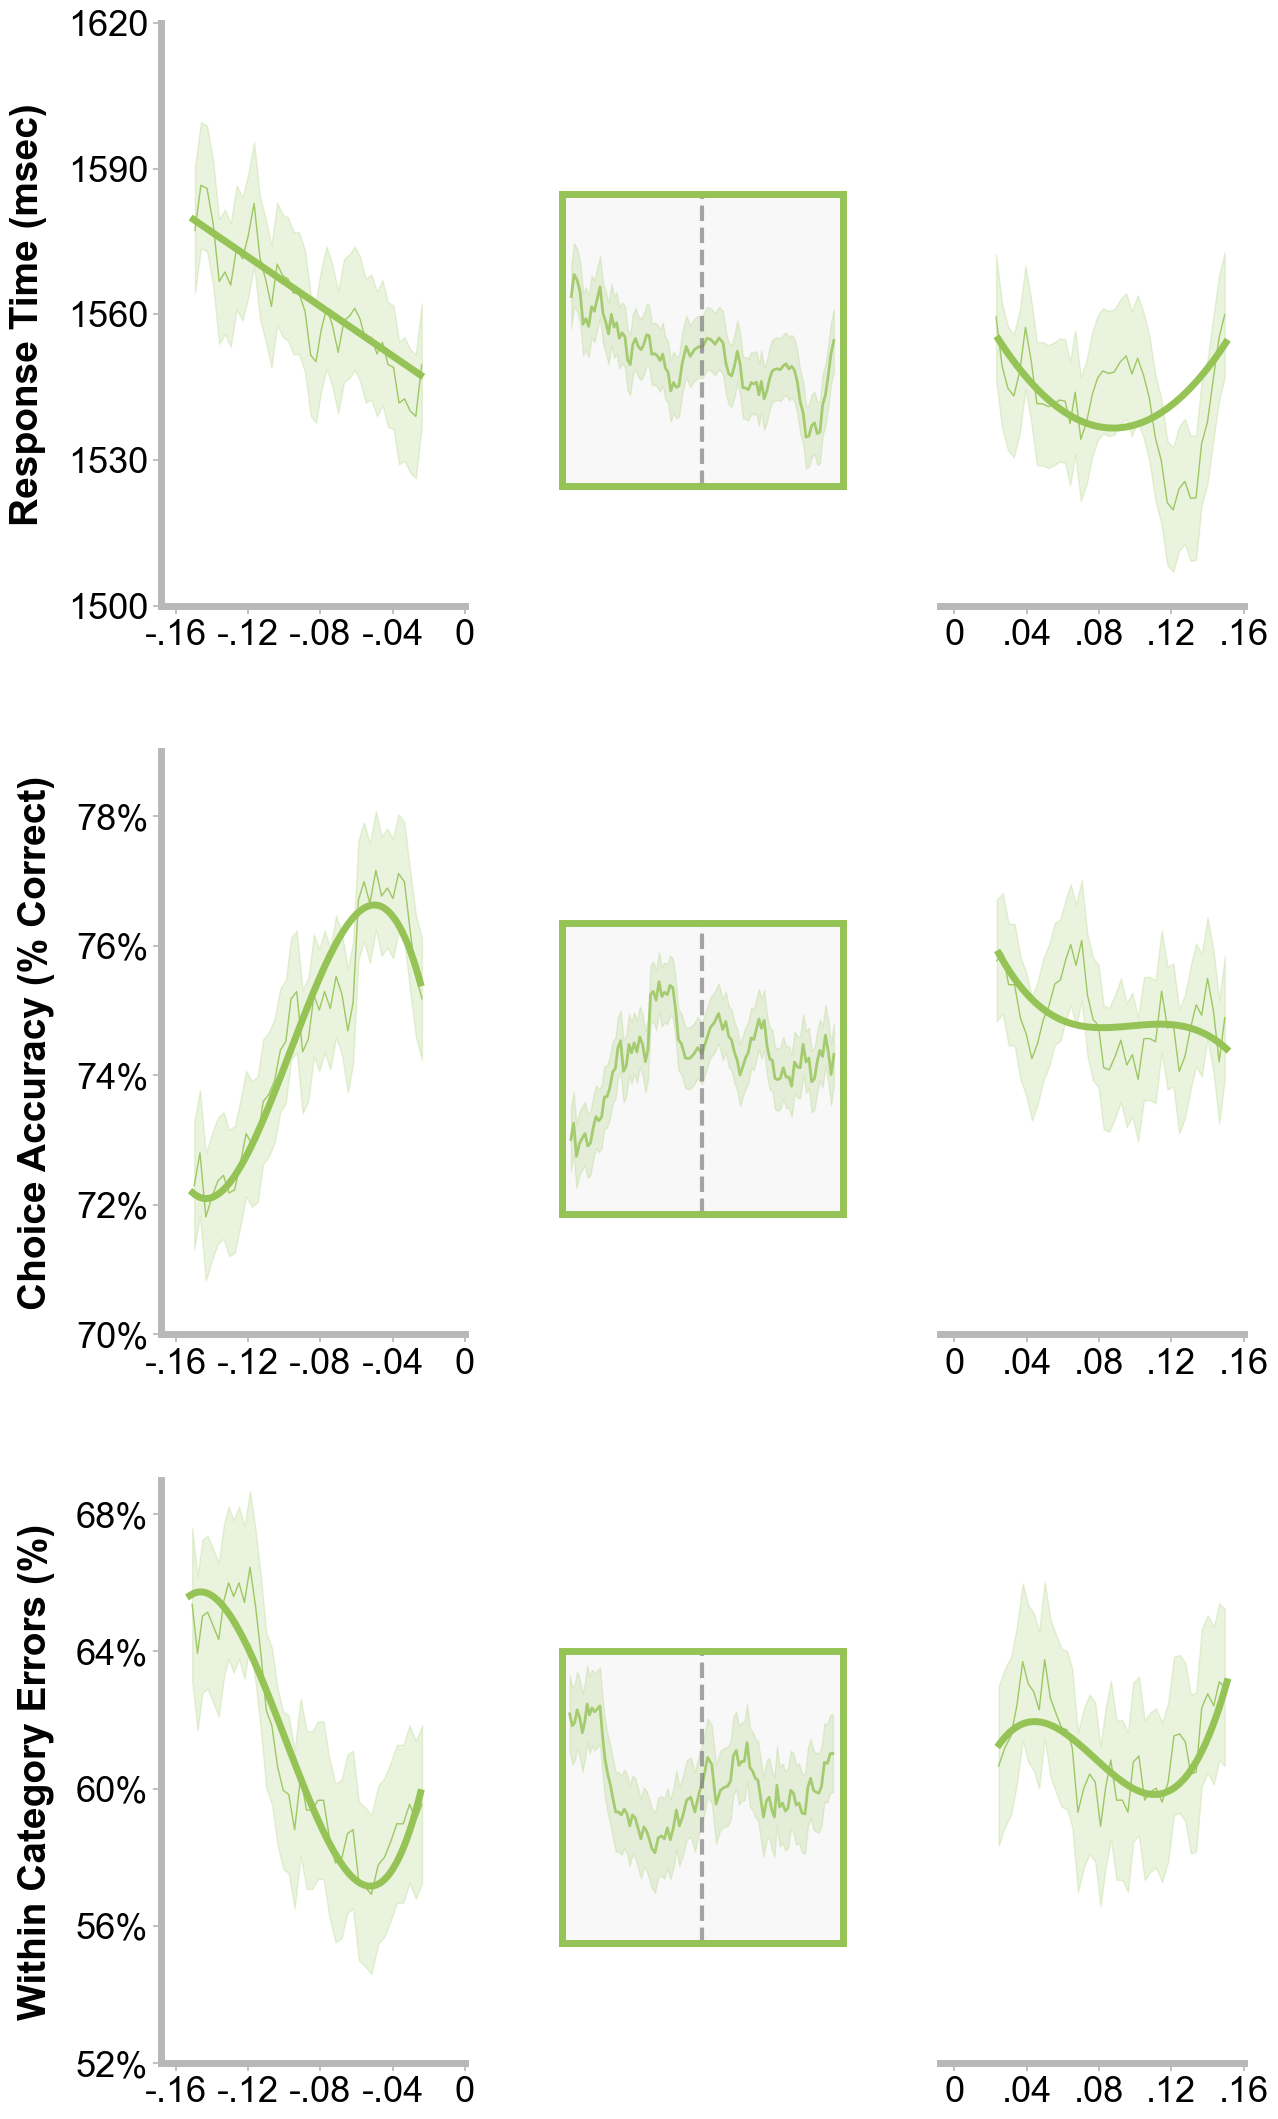

In [16]:
# fig_v2 = create_three_panel_visualization(
#     plot_configs_v2,
#     middle_width=0.35,
#     middle_height_shift=0.05,
#     middle_size_scale=0.5,
#     adjustable_gap=-0.03,
#     # grey_out_models={1: {'right': True}},  # Grey out row 2, right panel
#     x_buffer_percent=0.05  # 5% buffer space between y-axis and plot data
# )

fig, model_fits = create_three_panel_visualization(
    plot_configs_v2,
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03,
    # grey_out_models={2: {'right': True}},
    x_buffer_percent=0.05,
    save_model_fits=True,  # Enable model fit saving
    model_fits_filename='trash'  # Custom filename
)

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
from matplotlib.ticker import FuncFormatter, MultipleLocator


def create_continuous_rolling_plot(df, x_col, y_col, item_col=None, 
                                 window_percent=0.1, step_percent=0.02,
                                 ax=None, 
                                 y_limits=None, x_limits=None,
                                 x_tick_step=None, y_tick_step=None, x_ticks=None,
                                 y_as_percentage=False, y_percentage_step=2,
                                 font_family='Arial',
                                 title_font_size=18, title_font_color='black', title_font_weight='bold',
                                 label_font_size=16, label_font_color='black', label_font_weight='bold',
                                 tick_font_size=14, tick_font_color='black',
                                 line_width=3, confidence_alpha=0.2,
                                 show_title=True,
                                 # NEW PARAMETERS FOR MODEL FIT EXTRACTION
                                 save_accuracy_model_fits=False, model_fits_storage=None,
                                 model_order=2, trim_percentile=0):
    
    if "IT Distractor Similarity" in x_col:
        palette = ['#49a791']
    elif "V2 Distractor Similarity" in x_col:
        palette = ['#95c355']
    else:
        palette = ['#49a791']
    
    # Check if we should save model fits
    should_save_model_fits = (save_accuracy_model_fits and 
                             model_fits_storage is not None and 
                             'accuracy' in y_col.lower() and
                             'error' not in y_col.lower())
    
    if should_save_model_fits:
        # Initialize storage for left and right sides
        if 'left_side' not in model_fits_storage:
            model_fits_storage['left_side'] = {}
        if 'right_side' not in model_fits_storage:
            model_fits_storage['right_side'] = {}
    
    # Compute rolling averages and extract model fits if needed
    if should_save_model_fits or ax is not None:
        # Process each item separately or all data together
        if item_col is not None and item_col in df.columns:
            items = df[item_col].unique()
            
            for i, item in enumerate(items):
                df_item = df[df[item_col] == item].copy()
                df_item = df_item.sort_values(by=x_col).reset_index(drop=True)
                total_points = len(df_item)
                
                window_points = max(int(total_points * window_percent), 3)
                step_points = max(int(total_points * step_percent), 1)
                color = palette[i % len(palette)]
                
                if total_points >= window_points:
                    print(f"Continuous rolling - {item}, Total points: {total_points}, "
                          f"Window size: {window_points}, Step size: {step_points}")
                    
                    # Compute rolling averages
                    x_vals, y_vals, y_errs = [], [], []
                    for j in range(0, total_points - window_points + 1, step_points):
                        window = df_item.iloc[j:j+window_points]
                        mean_x = window[x_col].mean()
                        mean_y = window[y_col].mean()
                        std_y = window[y_col].std()
                        sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                        x_vals.append(mean_x)
                        y_vals.append(mean_y)
                        y_errs.append(sem_y)
                    
                    x_vals = np.array(x_vals)
                    y_vals = np.array(y_vals)
                    y_errs = np.array(y_errs)
                    
                    # Plot rolling averages if ax is provided
                    if ax is not None and len(x_vals) > 0:
                        ax.plot(x_vals, y_vals, color=color, linewidth=line_width, 
                               alpha=0.8, label=f'{item} (rolling)')
                        ax.fill_between(x_vals, 
                                       y_vals - 1.96 * y_errs,
                                       y_vals + 1.96 * y_errs,
                                       color=color, alpha=confidence_alpha)
                    
                    # Extract model fits if needed
                    if should_save_model_fits and len(x_vals) >= 5:
                        # Create DataFrame from rolling averages for model fitting
                        rolling_df = pd.DataFrame({
                            x_col: x_vals,
                            y_col: y_vals
                        })
                        
                        # Apply trimming if specified
                        if trim_percentile > 0:
                            lower_p = np.percentile(rolling_df[x_col], trim_percentile)
                            upper_p = np.percentile(rolling_df[x_col], 100 - trim_percentile)
                            rolling_df_trimmed = rolling_df[(rolling_df[x_col] >= lower_p) & (rolling_df[x_col] <= upper_p)]
                        else:
                            rolling_df_trimmed = rolling_df
                        
                        # Split at x=0 and create model fits for each side
                        left_data = rolling_df_trimmed[rolling_df_trimmed[x_col] <= 0]
                        right_data = rolling_df_trimmed[rolling_df_trimmed[x_col] > 0]
                        
                        # Left side model fit (x <= 0)
                        if len(left_data) >= 3:
                            # For accuracy data, extend TO x=0
                            model_min_x = left_data[x_col].min()
                            model_max_x = 0  # Always extend to x=0
                            
                            print(f"  📊 Continuous Left - {item} Accuracy Model Fit (extended to x=0):")
                            print(f"     Rolling average points: {len(left_data)}")
                            print(f"     Model range: x=[{model_min_x:.3f}, {model_max_x:.3f}]")
                            
                            if model_max_x > model_min_x:
                                x_range = np.linspace(model_min_x, model_max_x, 100)
                                model = np.poly1d(np.polyfit(left_data[x_col], left_data[y_col], model_order))
                                model_predictions = model(x_range)
                                
                                # Extended range for continuous plotting
                                extended_x_range = np.linspace(model_min_x - 0.1, model_max_x + 0.1, 200)
                                extended_predictions = model(extended_x_range)
                                
                                model_key = f"{item}"
                                model_fits_storage['left_side'][model_key] = {
                                    'x_values': x_range.tolist(),
                                    'y_values': model_predictions.tolist(),
                                    'extended_x_values': extended_x_range.tolist(),
                                    'extended_y_values': extended_predictions.tolist(),
                                    'model_coefficients': model.coefficients.tolist(),
                                    'model_order': model_order,
                                    'x_range_min': float(model_min_x),
                                    'x_range_max': float(model_max_x),
                                    'color': color,
                                    'item_name': str(item),
                                    'x_col': x_col,
                                    'y_col': y_col,
                                    'side': 'left',
                                    'trim_percentile': trim_percentile,
                                    'points_used_in_fit': int(len(left_data)),
                                    'total_points_available': int(len(rolling_df)),
                                    'polynomial_function': {
                                        'coefficients': model.coefficients.tolist(),
                                        'order': model_order,
                                        'domain_min': float(model_min_x),
                                        'domain_max': float(model_max_x)
                                    }
                                }
                        
                        # Right side model fit (x > 0)
                        if len(right_data) >= 3:
                            # For accuracy data, start FROM x=0
                            model_min_x = 0  # Always start from x=0
                            model_max_x = right_data[x_col].max()
                            
                            print(f"  📊 Continuous Right - {item} Accuracy Model Fit (starting from x=0):")
                            print(f"     Rolling average points: {len(right_data)}")
                            print(f"     Model range: x=[{model_min_x:.3f}, {model_max_x:.3f}]")
                            
                            if model_max_x > model_min_x:
                                x_range = np.linspace(model_min_x, model_max_x, 100)
                                model = np.poly1d(np.polyfit(right_data[x_col], right_data[y_col], model_order))
                                model_predictions = model(x_range)
                                
                                # Extended range for continuous plotting
                                extended_x_range = np.linspace(model_min_x - 0.1, model_max_x + 0.1, 200)
                                extended_predictions = model(extended_x_range)
                                
                                model_key = f"{item}"
                                model_fits_storage['right_side'][model_key] = {
                                    'x_values': x_range.tolist(),
                                    'y_values': model_predictions.tolist(),
                                    'extended_x_values': extended_x_range.tolist(),
                                    'extended_y_values': extended_predictions.tolist(),
                                    'model_coefficients': model.coefficients.tolist(),
                                    'model_order': model_order,
                                    'x_range_min': float(model_min_x),
                                    'x_range_max': float(model_max_x),
                                    'color': color,
                                    'item_name': str(item),
                                    'x_col': x_col,
                                    'y_col': y_col,
                                    'side': 'right',
                                    'trim_percentile': trim_percentile,
                                    'points_used_in_fit': int(len(right_data)),
                                    'total_points_available': int(len(rolling_df)),
                                    'polynomial_function': {
                                        'coefficients': model.coefficients.tolist(),
                                        'order': model_order,
                                        'domain_min': float(model_min_x),
                                        'domain_max': float(model_max_x)
                                    }
                                }
        
        else:  # No item_col, process all data together
            df_copy = df.copy().sort_values(by=x_col).reset_index(drop=True)
            total_points = len(df_copy)
            
            window_points = max(int(total_points * window_percent), 3)
            step_points = max(int(total_points * step_percent), 1)
            color = palette[0]
            
            if total_points >= window_points:
                print(f"Continuous rolling - All Data, Total points: {total_points}, "
                      f"Window size: {window_points}, Step size: {step_points}")
                
                # Compute rolling averages
                x_vals, y_vals, y_errs = [], [], []
                for j in range(0, total_points - window_points + 1, step_points):
                    window = df_copy.iloc[j:j+window_points]
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    std_y = window[y_col].std()
                    sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                    x_vals.append(mean_x)
                    y_vals.append(mean_y)
                    y_errs.append(sem_y)
                
                x_vals = np.array(x_vals)
                y_vals = np.array(y_vals)
                y_errs = np.array(y_errs)
                
                # Plot rolling averages if ax is provided
                if ax is not None and len(x_vals) > 0:
                    ax.plot(x_vals, y_vals, color=color, linewidth=line_width, 
                           alpha=0.8, label='Rolling average')
                    ax.fill_between(x_vals, 
                                   y_vals - 1.96 * y_errs,
                                   y_vals + 1.96 * y_errs,
                                   color=color, alpha=confidence_alpha)
                
                # Extract model fits if needed
                if should_save_model_fits and len(x_vals) >= 5:
                    # Create DataFrame from rolling averages for model fitting
                    rolling_df = pd.DataFrame({
                        x_col: x_vals,
                        y_col: y_vals
                    })
                    
                    # Apply trimming if specified
                    if trim_percentile > 0:
                        lower_p = np.percentile(rolling_df[x_col], trim_percentile)
                        upper_p = np.percentile(rolling_df[x_col], 100 - trim_percentile)
                        rolling_df_trimmed = rolling_df[(rolling_df[x_col] >= lower_p) & (rolling_df[x_col] <= upper_p)]
                    else:
                        rolling_df_trimmed = rolling_df
                    
                    # Split at x=0 and create model fits for each side
                    left_data = rolling_df_trimmed[rolling_df_trimmed[x_col] <= 0]
                    right_data = rolling_df_trimmed[rolling_df_trimmed[x_col] > 0]
                    
                    # Left side model fit (x <= 0)
                    if len(left_data) >= 3:
                        model_min_x = left_data[x_col].min()
                        model_max_x = 0  # Always extend to x=0
                        
                        print(f"  📊 Continuous Left - All Data Accuracy Model Fit (extended to x=0):")
                        print(f"     Rolling average points: {len(left_data)}")
                        print(f"     Model range: x=[{model_min_x:.3f}, {model_max_x:.3f}]")
                        
                        if model_max_x > model_min_x:
                            x_range = np.linspace(model_min_x, model_max_x, 100)
                            model = np.poly1d(np.polyfit(left_data[x_col], left_data[y_col], model_order))
                            model_predictions = model(x_range)
                            
                            extended_x_range = np.linspace(model_min_x - 0.1, model_max_x + 0.1, 200)
                            extended_predictions = model(extended_x_range)
                            
                            model_key = "all_data"
                            model_fits_storage['left_side'][model_key] = {
                                'x_values': x_range.tolist(),
                                'y_values': model_predictions.tolist(),
                                'extended_x_values': extended_x_range.tolist(),
                                'extended_y_values': extended_predictions.tolist(),
                                'model_coefficients': model.coefficients.tolist(),
                                'model_order': model_order,
                                'x_range_min': float(model_min_x),
                                'x_range_max': float(model_max_x),
                                'color': color,
                                'item_name': 'all_data',
                                'x_col': x_col,
                                'y_col': y_col,
                                'side': 'left',
                                'trim_percentile': trim_percentile,
                                'points_used_in_fit': int(len(left_data)),
                                'total_points_available': int(len(rolling_df)),
                                'polynomial_function': {
                                    'coefficients': model.coefficients.tolist(),
                                    'order': model_order,
                                    'domain_min': float(model_min_x),
                                    'domain_max': float(model_max_x)
                                }
                            }
                    
                    # Right side model fit (x > 0)
                    if len(right_data) >= 3:
                        model_min_x = 0  # Always start from x=0
                        model_max_x = right_data[x_col].max()
                        
                        print(f"  📊 Continuous Right - All Data Accuracy Model Fit (starting from x=0):")
                        print(f"     Rolling average points: {len(right_data)}")
                        print(f"     Model range: x=[{model_min_x:.3f}, {model_max_x:.3f}]")
                        
                        if model_max_x > model_min_x:
                            x_range = np.linspace(model_min_x, model_max_x, 100)
                            model = np.poly1d(np.polyfit(right_data[x_col], right_data[y_col], model_order))
                            model_predictions = model(x_range)
                            
                            extended_x_range = np.linspace(model_min_x - 0.1, model_max_x + 0.1, 200)
                            extended_predictions = model(extended_x_range)
                            
                            model_key = "all_data"
                            model_fits_storage['right_side'][model_key] = {
                                'x_values': x_range.tolist(),
                                'y_values': model_predictions.tolist(),
                                'extended_x_values': extended_x_range.tolist(),
                                'extended_y_values': extended_predictions.tolist(),
                                'model_coefficients': model.coefficients.tolist(),
                                'model_order': model_order,
                                'x_range_min': float(model_min_x),
                                'x_range_max': float(model_max_x),
                                'color': color,
                                'item_name': 'all_data',
                                'x_col': x_col,
                                'y_col': y_col,
                                'side': 'right',
                                'trim_percentile': trim_percentile,
                                'points_used_in_fit': int(len(right_data)),
                                'total_points_available': int(len(rolling_df)),
                                'polynomial_function': {
                                    'coefficients': model.coefficients.tolist(),
                                    'order': model_order,
                                    'domain_min': float(model_min_x),
                                    'domain_max': float(model_max_x)
                                }
                            }
    
    # Continue with original plotting code if ax is provided
    if ax is not None:
        ax.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=3)
        
        if show_title:
            ax.set_title("Continuous", fontsize=title_font_size-2, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=15)
        
        ax.set_xlabel('')
        ax.tick_params(axis='x', bottom=False, labelbottom=False)
        ax.spines['bottom'].set_visible(False)
        
        # Set limits and formatting
        if y_limits is not None:
            ax.set_ylim(y_limits)
        if x_limits is not None:
            ax.set_xlim(x_limits)
        
        if x_tick_step is not None:
            ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
        if y_tick_step is not None:
            ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
        
        if y_as_percentage:
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
        
        ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        
        # Style the plot
        spine_color = '#B8B8B8'
        ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size-2, labelcolor=tick_font_color)
        ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size-2, labelcolor=tick_font_color)
        
        for label in ax.get_xticklabels():
            label.set_fontfamily(font_family)
        for label in ax.get_yticklabels():
            label.set_fontfamily(font_family)
    
    return ax


def create_single_side_plot(df, x_col, y_col, item_col=None, 
                           split_col='v2_pos_neg', split_value=0, side='left',
                           window_percent=0.2, step_percent=0.02,
                           ax=None, palette=None,
                           y_limits=None, x_limits=None,
                           x_tick_step=None, y_tick_step=None,
                           model_order=2, trim_percentile=0,
                           y_as_percentage=False, y_percentage_step=2,
                           x_buffer_percent=0.05,
                           font_family='Arial',
                           title_font_size=18, title_font_color='black', title_font_weight='bold',
                           label_font_size=16, label_font_color='black', label_font_weight='bold',
                           tick_font_size=14, tick_font_color='black',
                           rolling_line_width=1, model_line_width=5,
                           confidence_alpha=0.2, rolling_alpha=0.9,
                           show_title=True, show_ylabel=True, show_xlabel=True,
                           grey_out_model=False,
                           # REMOVED MODEL FIT EXTRACTION - NOW HANDLED BY CONTINUOUS PLOT
                           save_accuracy_model_fits=False, model_fits_storage=None):
    
    grey = '#BFBFBF'
    blue = '#6cbcef'
    teal = '#49a791'
    purple = '#a271b1'
    salmon = '#e58a72'
    gold = '#dbad40'
    green = '#95c355'
    
    if palette is None:
        if "IT Distractor Similarity" in x_col:
            default_colors = [teal, grey]
        elif "V2 Distractor Similarity" in x_col:
            default_colors = [green, grey]
        else:
            default_colors = [teal, grey]
    else:
        default_colors = palette
    
    color_map = {
        'prioritized': default_colors[0],    
        'deprioritized': default_colors[1] if len(default_colors) > 1 else grey,  
    }
    
    if side == 'left':
        df_side = df[df[x_col] <= split_value].copy()
        title_text = f"{x_col} ≤ {split_value}"
    else:
        df_side = df[df[x_col] > split_value].copy()
        title_text = f"{x_col} > {split_value}"
    
    ax.set_facecolor('white')
    
    item_color_dict = {}
    if item_col is not None and item_col in df.columns:
        all_items = df[item_col].unique()
        for i, item in enumerate(all_items):
            item_lower = str(item).lower()
            if item_lower in color_map:
                item_color_dict[item] = color_map[item_lower]
            elif 'prioritized' in item_lower:
                item_color_dict[item] = color_map['prioritized']
            elif 'deprioritized' in item_lower:
                item_color_dict[item] = color_map['deprioritized']
            else:
                item_color_dict[item] = default_colors[i % len(default_colors)]
    
    # NOTE: Model fit extraction removed from side plots - now handled by continuous plot
    
    if item_col is not None and item_col in df.columns:
        items = df_side[item_col].unique()
        
        for i, item in enumerate(items):
            df_item = df_side[df_side[item_col] == item].copy()
            df_item = df_item.sort_values(by=x_col).reset_index(drop=True)
            total_points = len(df_item)
            
            window_points = max(int(total_points * window_percent), 3)
            step_points = max(int(total_points * step_percent), 1)
            color = item_color_dict.get(item, default_colors[i % len(default_colors)])
            
            if total_points >= window_points:
                print(f"{side} side - {item}, Total points: {total_points}, "
                      f"Window size: {window_points}, Step size: {step_points}")
                
                x_vals, y_vals, y_errs = [], [], []
                for j in range(0, total_points - window_points + 1, step_points):
                    window = df_item.iloc[j:j+window_points]
                    mean_x = window[x_col].mean()
                    mean_y = window[y_col].mean()
                    std_y = window[y_col].std()
                    sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                    x_vals.append(mean_x)
                    y_vals.append(mean_y)
                    y_errs.append(sem_y)
                
                x_vals = np.array(x_vals)
                y_vals = np.array(y_vals)
                y_errs = np.array(y_errs)
                
                if len(x_vals) > 0:
                    ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                           alpha=rolling_alpha, label=f'{item} (rolling)')
                    ax.fill_between(x_vals, 
                                   y_vals - 1.96 * y_errs,
                                   y_vals + 1.96 * y_errs,
                                   color=color, alpha=confidence_alpha)
        
        # Only plot model fits if grey_out_model is False
        if not grey_out_model:
            for i, item in enumerate(items):
                df_item = df_side[df_side[item_col] == item].copy()
                
                if trim_percentile > 0:
                    lower_p = np.percentile(df_item[x_col], trim_percentile)
                    upper_p = np.percentile(df_item[x_col], 100 - trim_percentile)
                    df_item_trimmed = df_item[(df_item[x_col] >= lower_p) & (df_item[x_col] <= upper_p)]
                else:
                    df_item_trimmed = df_item
                    
                total_points = len(df_item_trimmed)
                color = item_color_dict.get(item, default_colors[i % len(default_colors)])
                
                if total_points >= 5:
                    total_points_full = len(df_item)
                    window_points_full = max(int(total_points_full * window_percent), 3)
                    
                    df_item_sorted = df_item.sort_values(by=x_col)
                    rolling_min_x = df_item_sorted.iloc[window_points_full//2][x_col]
                    rolling_max_x = df_item_sorted.iloc[-(window_points_full//2 + 1)][x_col]
                    
                    points_below_rolling = len(df_item_trimmed[df_item_trimmed[x_col] < rolling_min_x])
                    points_above_rolling = len(df_item_trimmed[df_item_trimmed[x_col] > rolling_max_x])
                    
                    model_min_x = max(df_item_trimmed[x_col].min(), rolling_min_x)
                    model_max_x = min(df_item_trimmed[x_col].max(), rolling_max_x)
                    
                    points_in_model = len(df_item_trimmed[
                        (df_item_trimmed[x_col] >= model_min_x) & 
                        (df_item_trimmed[x_col] <= model_max_x)
                    ])
                    
                    points_excluded_by_trim = len(df_item) - len(df_item_trimmed)
                    
                    print(f"  📊 {side} side - {item} Model Fit Exclusions:")
                    print(f"     Total points: {len(df_item)}")
                    if trim_percentile > 0:
                        print(f"     Excluded by trimming ({trim_percentile}%): {points_excluded_by_trim}")
                        print(f"     Remaining after trim: {len(df_item_trimmed)}")
                    else:
                        print(f"     No trimming applied")
                    print(f"     Excluded by rolling constraint - Left edge: {points_below_rolling}")
                    print(f"     Excluded by rolling constraint - Right edge: {points_above_rolling}")
                    print(f"     Points used in model fit: {points_in_model}")
                    print(f"     Total excluded: {len(df_item) - points_in_model}")
                    
                    if model_max_x > model_min_x:
                        x_range = np.linspace(model_min_x, model_max_x, 100)
                        model = np.poly1d(np.polyfit(df_item_trimmed[x_col], df_item_trimmed[y_col], model_order))
                        
                        ax.plot(x_range, model(x_range), color=color, linestyle='-', 
                                linewidth=model_line_width, label=f'{item} (model)')
    else:
        df_side_copy = df_side.copy().sort_values(by=x_col).reset_index(drop=True)
        total_points = len(df_side_copy)
        
        window_points = max(int(total_points * window_percent), 3)
        step_points = max(int(total_points * step_percent), 1)
        color = default_colors[0]
        
        if total_points >= window_points:
            print(f"{side} side - All Data, Total points: {total_points}, "
                  f"Window size: {window_points}, Step size: {step_points}")
            
            x_vals, y_vals, y_errs = [], [], []
            for j in range(0, total_points - window_points + 1, step_points):
                window = df_side_copy.iloc[j:j+window_points]
                mean_x = window[x_col].mean()
                mean_y = window[y_col].mean()
                std_y = window[y_col].std()
                sem_y = std_y / np.sqrt(window_points) if std_y > 0 else 0
                x_vals.append(mean_x)
                y_vals.append(mean_y)
                y_errs.append(sem_y)
            
            x_vals = np.array(x_vals)
            y_vals = np.array(y_vals)
            y_errs = np.array(y_errs)
            
            if len(x_vals) > 0:
                ax.plot(x_vals, y_vals, color=color, linewidth=rolling_line_width, 
                       alpha=rolling_alpha, label='Rolling average')
                ax.fill_between(x_vals, 
                               y_vals - 1.96 * y_errs,
                               y_vals + 1.96 * y_errs,
                               color=color, alpha=confidence_alpha)
        
        # Only plot model fits if grey_out_model is False
        if not grey_out_model:
            if trim_percentile > 0:
                lower_p = np.percentile(df_side_copy[x_col], trim_percentile)
                upper_p = np.percentile(df_side_copy[x_col], 100 - trim_percentile)
                df_side_trimmed = df_side_copy[(df_side_copy[x_col] >= lower_p) & (df_side_copy[x_col] <= upper_p)]
            else:
                df_side_trimmed = df_side_copy
                
            total_points_trimmed = len(df_side_trimmed)
            
            if total_points_trimmed >= 5:
                window_points_full = max(int(total_points * window_percent), 3)
                
                df_side_sorted = df_side_copy.sort_values(by=x_col)
                rolling_min_x = df_side_sorted.iloc[window_points_full//2][x_col]
                rolling_max_x = df_side_sorted.iloc[-(window_points_full//2 + 1)][x_col]
                
                points_below_rolling = len(df_side_trimmed[df_side_trimmed[x_col] < rolling_min_x])
                points_above_rolling = len(df_side_trimmed[df_side_trimmed[x_col] > rolling_max_x])
                
                model_min_x = max(df_side_trimmed[x_col].min(), rolling_min_x)
                model_max_x = min(df_side_trimmed[x_col].max(), rolling_max_x)
                
                points_in_model = len(df_side_trimmed[
                    (df_side_trimmed[x_col] >= model_min_x) & 
                    (df_side_trimmed[x_col] <= model_max_x)
                ])
                
                points_excluded_by_trim = len(df_side_copy) - len(df_side_trimmed)
                
                print(f"  📊 {side} side - All Data Model Fit Exclusions:")
                print(f"     Total points: {len(df_side_copy)}")
                if trim_percentile > 0:
                    print(f"     Excluded by trimming ({trim_percentile}%): {points_excluded_by_trim}")
                    print(f"     Remaining after trim: {len(df_side_trimmed)}")
                else:
                    print(f"     No trimming applied")
                print(f"     Excluded by rolling constraint - Left edge: {points_below_rolling}")
                print(f"     Excluded by rolling constraint - Right edge: {points_above_rolling}")
                print(f"     Points used in model fit: {points_in_model}")
                print(f"     Total excluded: {len(df_side_copy) - points_in_model}")
                
                if model_max_x > model_min_x:
                    x_range = np.linspace(model_min_x, model_max_x, 100)
                    model = np.poly1d(np.polyfit(df_side_trimmed[x_col], df_side_trimmed[y_col], model_order))
                    
                    ax.plot(x_range, model(x_range), color=color, linestyle='-', 
                            linewidth=model_line_width, label='Model fit')
    
    if show_title:
        if side == 'left':
            ax.set_title("Negative", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
        else:
            ax.set_title("Positive", fontsize=title_font_size, 
                        color=title_font_color, fontweight=title_font_weight, 
                        fontfamily=font_family, pad=20)
    
    if show_xlabel:
        if x_col in ["Tested - Untested IT Distractor Similarity"]:
            ax.set_xlabel("Relative IT Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif x_col in ["Tested - Untested V2 Distractor Similarity"]:
            ax.set_xlabel("Relative V2 Similarity", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_xlabel(x_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    else:
        ax.set_xlabel('')
    
    if show_ylabel:
        if y_col.lower() in ['accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Choice Accuracy (% Correct)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['wm rt']:
            ax.set_ylabel("Response Time (msec)", fontweight=label_font_weight, 
                         fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        elif y_col.lower() in ['error category accuracy']:
            if y_as_percentage:
                ax.set_ylabel("Within Category Errors (%)", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
                if y_tick_step is None:
                    y_tick_step = y_percentage_step / 100.0
            else:
                ax.set_ylabel("Within Category Errors", fontweight=label_font_weight, 
                             fontsize=label_font_size, color=label_font_color, fontfamily=font_family, labelpad=15)
        else:
            ax.set_ylabel(y_col, fontweight=label_font_weight, fontsize=label_font_size, 
                         color=label_font_color, fontfamily=font_family, labelpad=15)
    
    if x_tick_step is not None:
        ax.xaxis.set_major_locator(MultipleLocator(x_tick_step))
    if y_tick_step is not None:
        ax.yaxis.set_major_locator(MultipleLocator(y_tick_step))
    
    # Handle x-limits with buffer space from y-axis
    if x_limits is not None:
        if side == 'left':
            # For left side, extend further left to create buffer from y-axis
            x_min, x_max = x_limits[0], split_value
            x_range = abs(x_max - x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(x_min - buffer, x_max)
        else:
            # For right side, extend leftward (toward 0) to create buffer from y-axis  
            x_min, x_max = split_value, x_limits[1]
            x_range = abs(x_max - x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(x_min - buffer, x_max)
    else:
        # If no x_limits provided, get data range and add buffer
        if side == 'left':
            data_x_min = df_side[x_col].min()
            x_range = abs(split_value - data_x_min)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(data_x_min - buffer, split_value)
        else:
            data_x_max = df_side[x_col].max()
            x_range = abs(data_x_max - split_value)
            buffer = x_range * x_buffer_percent
            ax.set_xlim(split_value - buffer, data_x_max)
    
    # Handle y-limits (keeping existing logic but simplifying)
    if y_limits is not None:
        ax.set_ylim(y_limits)
    elif y_col.lower() in ['accuracy', 'acc', 'correct', 'resp_correct']:
        ax.set_ylim(0.6, 0.8)
    
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    spine_color = '#B8B8B8'
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, labelcolor=tick_font_color)
    
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color(spine_color)
    ax.spines['left'].set_color(spine_color)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.grid(False)
    
    return ax

def create_three_panel_visualization(plot_configs, middle_width=0.35, middle_height_shift=0.0, 
                                   middle_size_scale=0.7, adjustable_gap=0.01, 
                                   grey_out_models=None, x_buffer_percent=0.05,
                                   # MODIFIED PARAMETERS FOR CONTINUOUS ROLLING AVERAGE MODEL FIT EXTRACTION
                                   save_accuracy_model_fits=False, accuracy_model_fits_filename=None):
    """
    Create three-panel visualization with option to save ONLY row 1 (second row) accuracy model fits.
    Model fits are now extracted from the continuous rolling average (middle panel) instead of left/right panels.
    Excludes error accuracy measurements.
    
    Parameters:
    -----------
    grey_out_models : dict, optional
        Dictionary specifying which model fits to grey out.
        Format: {row_index: {'left': bool, 'right': bool}}
        Example: {2: {'right': True}} would grey out the model fit in row 2, right panel
    x_buffer_percent : float, optional
        Percentage of x-range to add as buffer space between y-axis and plot data (default: 0.05 = 5%)
    save_accuracy_model_fits : bool, optional
        Whether to extract and save ONLY row 1 accuracy model fit data (excludes error accuracy) (default: False)
    accuracy_model_fits_filename : str, optional
        Base filename for saving accuracy model fits. Will create both .pkl and .json files (default: 'accuracy_model_fits')
    
    Returns:
    --------
    fig : matplotlib figure
        The created figure
    accuracy_model_fits_data : dict (if save_accuracy_model_fits=True)
        Dictionary containing only row 1 accuracy model fit data extracted from continuous rolling averages
    """
    
    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=(18, 22))
    
    # Initialize accuracy model fits storage
    if save_accuracy_model_fits:
        all_accuracy_model_fits = {}
        if accuracy_model_fits_filename is None:
            accuracy_model_fits_filename = 'accuracy_model_fits'
    
    # Keep plot sizes FIXED regardless of gap size
    original_gap_width = 0.01
    original_remaining_width = 1.0 - middle_width - 2*original_gap_width
    fixed_side_width = original_remaining_width / 2 * 0.6
    fixed_middle_width = middle_width
    
    current_gap_width = adjustable_gap
    
    total_plot_width = 2 * fixed_side_width + fixed_middle_width + 2 * current_gap_width
    remaining_for_margins = 1.0 - total_plot_width
    outer_margin = remaining_for_margins / 2
    
    if outer_margin < 0.001:
        outer_margin = 0.001
    
    gs = GridSpec(3, 7, figure=fig, 
                  width_ratios=[outer_margin, fixed_side_width, current_gap_width, fixed_middle_width, current_gap_width, fixed_side_width, outer_margin],  
                  height_ratios=[1, 1, 1],   
                  hspace=0.25, wspace=0.01,
                  top=0.95, bottom=0.1, left=0.05, right=0.95)
    axes = []
    for row in range(3):
        ax_left = fig.add_subplot(gs[row, 1])
        ax_middle = fig.add_subplot(gs[row, 3])
        ax_right = fig.add_subplot(gs[row, 5])
        axes.append([ax_left, ax_middle, ax_right])

    all_handles = []
    all_labels = []
    
    # Initialize grey_out_models if not provided
    if grey_out_models is None:
        grey_out_models = {}
    
    for row, config in enumerate(plot_configs):
        x_col = config['x_col']
        y_col = config['y_col']
        
        # MODIFIED: Check if this is row 1 (second row) and contains pure accuracy data (not error accuracy)
        is_accuracy_row = (row == 1 and 
                          'accuracy' in y_col.lower() and 
                          'error' not in y_col.lower())
        
        if "IT Distractor Similarity" in x_col:
            frame_color = '#49a791'
        elif "V2 Distractor Similarity" in x_col:
            frame_color = '#95c355'
        else:
            frame_color = '#49a791'
        
        y_limits = config.get('y_limits')
        
        # Check if left side should be greyed out
        grey_left = grey_out_models.get(row, {}).get('left', False)
        grey_right = grey_out_models.get(row, {}).get('right', False)
        
        # Initialize storage for this row's accuracy model fits only
        if save_accuracy_model_fits and is_accuracy_row:
            row_accuracy_model_fits = {}
            print(f"\n🎯 Row {row}: Extracting model fits from continuous rolling average (y_col='{y_col}')")
        else:
            row_accuracy_model_fits = None
            if save_accuracy_model_fits and not is_accuracy_row:
                if row != 1:
                    print(f"\n⏭️  Row {row}: Skipping - only saving row 1 (second row)")
                elif 'error' in y_col.lower():
                    print(f"\n⏭️  Row {row}: Skipping - excluding error accuracy (y_col='{y_col}')")
                elif 'accuracy' not in y_col.lower():
                    print(f"\n⏭️  Row {row}: Skipping - not accuracy data (y_col='{y_col}')")
        
        create_single_side_plot(
            config['df'],
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            side='left',
            ax=axes[row][0],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            model_order=config.get('left_model_order', 2),
            trim_percentile=config.get('trim_percentile', 0),
            window_percent=config.get('window_percent', 0.2),
            step_percent=config.get('step_percent', 0.02),
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            x_buffer_percent=x_buffer_percent,
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 16),
            tick_font_size=config.get('tick_font_size', 14),
            show_title=False,
            show_ylabel=True,
            show_xlabel=False,
            grey_out_model=grey_left,
            # Model fit extraction removed from side plots
            save_accuracy_model_fits=False,
            model_fits_storage=None
        )
        
        axes[row][0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        
        # MODIFIED: Extract model fits from continuous rolling average
        create_continuous_rolling_plot(
            config['df'],
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            ax=axes[row][1],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            x_ticks=config.get('x_ticks'),
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 14),
            tick_font_size=config.get('tick_font_size', 12),
            window_percent=0.1,
            step_percent = 0.01,
            line_width=2,
            show_title=False,
            # NEW: Extract model fits from continuous rolling average
            save_accuracy_model_fits=save_accuracy_model_fits,
            model_fits_storage=row_accuracy_model_fits if row_accuracy_model_fits is not None else None,
            model_order=config.get('left_model_order', 2),  # Use same model order as left side
            trim_percentile=config.get('trim_percentile', 0)
        )
        
        axes[row][1].set_xlabel('')
        axes[row][1].tick_params(axis='x', bottom=False, labelbottom=False)
        axes[row][1].spines['bottom'].set_visible(False)
        
        for spine_name, spine in axes[row][1].spines.items():
            spine.set_visible(True)
            spine.set_linewidth(5)
            spine.set_color(frame_color)
        
        axes[row][1].set_facecolor('#f8f8f8')
        
        pos = axes[row][1].get_position()
        new_width = pos.width * middle_size_scale
        new_height = pos.height * middle_size_scale
        new_x = pos.x0 + (pos.width - new_width) / 2
        new_y = pos.y0 + middle_height_shift
        
        new_pos = [new_x, new_y, new_width, new_height]
        axes[row][1].set_position(new_pos)
        
        create_single_side_plot(
            config['df'],
            x_col=config['x_col'],
            y_col=config['y_col'],
            item_col=config.get('item_col'),
            side='right',
            ax=axes[row][2],
            y_limits=y_limits,
            x_limits=config.get('x_limits'),
            x_tick_step=config.get('x_tick_step'),
            y_tick_step=config.get('y_tick_step'),
            model_order=config.get('right_model_order', 2),
            trim_percentile=config.get('trim_percentile', 0),
            window_percent=config.get('window_percent', 0.2),
            step_percent=config.get('step_percent', 0.02),
            y_as_percentage=config.get('y_as_percentage', False),
            y_percentage_step=config.get('y_percentage_step', 2),
            x_buffer_percent=x_buffer_percent,
            font_family=config.get('font_family', 'Arial'),
            label_font_size=config.get('label_font_size', 16),
            tick_font_size=config.get('tick_font_size', 14),
            show_title=False,
            show_ylabel=False,
            show_xlabel=False,
            grey_out_model=grey_right,
            # Model fit extraction removed from side plots
            save_accuracy_model_fits=False,
            model_fits_storage=None
        )
        
        axes[row][2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        
        axes[row][1].set_ylabel('')
        axes[row][1].tick_params(axis='y', labelleft=False, left=False)
        
        axes[row][2].set_ylabel('')
        axes[row][2].tick_params(axis='y', labelleft=False, left=False)
        axes[row][2].spines['left'].set_visible(False)
        
        # Store accuracy model fits for this row (only if it was an accuracy row)
        if save_accuracy_model_fits and is_accuracy_row and row_accuracy_model_fits:
            row_key = f"row_{row}"
            all_accuracy_model_fits[row_key] = {
                'config': {
                    'x_col': config['x_col'],
                    'y_col': config['y_col'],
                    'item_col': config.get('item_col'),
                    'model_orders': {
                        'left': config.get('left_model_order', 2),
                        'right': config.get('right_model_order', 2)
                    },
                    'trim_percentile': config.get('trim_percentile', 0),
                    'window_percent': 0.1,  # From continuous rolling plot
                    'step_percent': 0.01    # From continuous rolling plot
                },
                'model_fits': row_accuracy_model_fits,
                'source': 'continuous_rolling_average'  # Mark the source
            }
        
        for col in range(3):
            handles, labels = axes[row][col].get_legend_handles_labels()
            for handle, label in zip(handles, labels):
                if "(" in label:
                    base_label = label.split("(")[0].strip()
                else:
                    base_label = label
                if base_label not in all_labels:
                    all_handles.append(handle)
                    all_labels.append(base_label)
        
        axes[row][0].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
        axes[row][2].xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Save accuracy model fits if requested
    if save_accuracy_model_fits:
        if all_accuracy_model_fits:  # Only save if we actually have accuracy data
            # Save as pickle file (preserves exact data types)
            with open(f'{accuracy_model_fits_filename}.pkl', 'wb') as f:
                pickle.dump(all_accuracy_model_fits, f)
            
            # Save as JSON file (human readable, but may have slight precision loss)
            with open(f'{accuracy_model_fits_filename}.json', 'w') as f:
                json.dump(all_accuracy_model_fits, f, indent=2)
            
        #     print(f"\n📁 Row 1 accuracy model fits (from continuous rolling average) saved to:")
        #     print(f"   - {accuracy_model_fits_filename}.pkl (pickle format)")
        #     print(f"   - {accuracy_model_fits_filename}.json (JSON format)")
        #     print(f"   Total accuracy rows processed: {len(all_accuracy_model_fits)} (row 1 only)")
        #     print(f"   Source: Continuous rolling average (middle panel)")
            
        #     # Print summary of saved data
        #     for row_key, row_data in all_accuracy_model_fits.items():
        #         print(f"\n{row_key} (y_col: {row_data['config']['y_col']}):")
        #         for side, side_data in row_data['model_fits'].items():
        #             print(f"  {side}: {len(side_data)} model fits")
        #             for model_key in side_data.keys():
        #                 print(f"    - {model_key}")
        # else:
        #     print(f"\n⚠️  No row 1 accuracy data found - no files saved")
    
    # plt.show()
    
    if save_accuracy_model_fits and all_accuracy_model_fits:
        return fig, all_accuracy_model_fits
    else:
        return fig


# ENHANCED UTILITY FUNCTIONS FOR WORKING WITH CONTINUOUS ROLLING AVERAGE ACCURACY MODEL FITS

def load_accuracy_model_fits(filename):
    """
    Load accuracy model fits from saved files.
    
    Parameters:
    -----------
    filename : str
        Base filename (without extension). Will try to load .pkl first, then .json
        
    Returns:
    --------
    dict : Accuracy model fits data
    """
    import os
    
    # Try pickle first (preserves exact data types)
    pickle_file = f"{filename}.pkl"
    json_file = f"{filename}.json"
    
    if os.path.exists(pickle_file):
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    elif os.path.exists(json_file):
        with open(json_file, 'r') as f:
            return json.load(f)
    else:
        raise FileNotFoundError(f"Neither {pickle_file} nor {json_file} found")

def create_continuous_model_fits(accuracy_model_fits_data, x_range_extension=0.2, num_points=500):
    """
    Create continuous left and right model fits from saved accuracy data.
    Left side fits ALWAYS extend TO x=0, right side fits ALWAYS start FROM x=0.
    
    Parameters:
    -----------
    accuracy_model_fits_data : dict
        Loaded accuracy model fits data
    x_range_extension : float
        How much to extend the x-range beyond the original domain (default: 0.2)
    num_points : int
        Number of points for the continuous curves (default: 500)
        
    Returns:
    --------
    dict : Dictionary containing continuous model fits for easy plotting
    """
    
    continuous_fits = {}
    
    for row_key, row_data in accuracy_model_fits_data.items():
        continuous_fits[row_key] = {
            'config': row_data['config'],
            'continuous_left': {},
            'continuous_right': {},
            'source': row_data.get('source', 'unknown')
        }
        
        # Process left and right sides
        for side_key, side_data in row_data['model_fits'].items():
            side = side_key.replace('_side', '')
            
            for model_key, model_info in side_data.items():
                # Get polynomial coefficients
                coeffs = model_info['model_coefficients']
                domain_min = model_info['x_range_min']
                domain_max = model_info['x_range_max']
                
                # Extend the domain, but respect x=0 boundary
                domain_range = domain_max - domain_min
                
                if side == 'left':
                    # Left side: extend leftward but ALWAYS end at x=0
                    extended_min = domain_min - (domain_range * x_range_extension)
                    extended_max = 0  # Always end at exactly x=0
                else:
                    # Right side: ALWAYS start at x=0 and extend rightward
                    extended_min = 0  # Always start at exactly x=0
                    extended_max = domain_max + (domain_range * x_range_extension)
                
                # Create extended x values
                x_extended = np.linspace(extended_min, extended_max, num_points)
                
                # Recreate polynomial and compute y values
                poly = np.poly1d(coeffs)
                y_extended = poly(x_extended)
                
                # Store continuous fit data
                continuous_data = {
                    'x_values': x_extended.tolist(),
                    'y_values': y_extended.tolist(),
                    'original_domain_min': domain_min,
                    'original_domain_max': domain_max,
                    'extended_domain_min': extended_min,
                    'extended_domain_max': extended_max,
                    'model_coefficients': coeffs,
                    'model_order': model_info['model_order'],
                    'color': model_info['color'],
                    'item_name': model_info['item_name'],
                    'x_col': model_info['x_col'],
                    'y_col': model_info['y_col'],
                    'side': side,
                    'source': row_data.get('source', 'unknown')
                }
                
                if side == 'left':
                    continuous_fits[row_key]['continuous_left'][model_key] = continuous_data
                else:
                    continuous_fits[row_key]['continuous_right'][model_key] = continuous_data
    
    return continuous_fits

def plot_continuous_accuracy_fits(continuous_fits_data, row_indices=None, 
                                figsize=(16, 8), save_plot=False, plot_filename='continuous_accuracy_fits'):
    """
    Plot continuous left and right accuracy model fits.
    
    Parameters:
    -----------
    continuous_fits_data : dict
        Output from create_continuous_model_fits()
    row_indices : list, optional
        Which rows to plot (default: all rows)
    figsize : tuple, optional
        Figure size (default: (16, 8))
    save_plot : bool, optional
        Whether to save the plot (default: False)
    plot_filename : str, optional
        Filename for saved plot (default: 'continuous_accuracy_fits')
    """
    
    if row_indices is None:
        row_indices = list(range(len(continuous_fits_data)))
    
    # Create subplot structure - fixed for single row case
    num_rows = len(row_indices)
    fig, axes = plt.subplots(num_rows, 2, figsize=figsize)
    
    # Handle single row case properly
    if num_rows == 1:
        axes = axes.reshape(1, -1)  # Make it (1, 2) shape
    
    for i, row_idx in enumerate(row_indices):
        row_key = f"row_{row_idx}"
        if row_key not in continuous_fits_data:
            continue
            
        row_data = continuous_fits_data[row_key]
        
        # Get the appropriate axes for this row
        ax_left = axes[i, 0]
        ax_right = axes[i, 1]
        
        # Plot left side (x < 0)
        for model_key, model_data in row_data['continuous_left'].items():
            x_vals = np.array(model_data['x_values'])
            y_vals = np.array(model_data['y_values'])
            color = model_data['color']
            
            ax_left.plot(x_vals, y_vals, color=color, linewidth=3, 
                        label=f"{model_data['item_name']}")
            
            # Highlight original domain
            orig_mask = (x_vals >= model_data['original_domain_min']) & (x_vals <= model_data['original_domain_max'])
            if np.any(orig_mask):
                ax_left.plot(x_vals[orig_mask], y_vals[orig_mask], color=color, linewidth=5, alpha=0.8)
        
        ax_left.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=2)
        source_info = row_data.get('source', 'unknown')
        ax_left.set_title(f"Row {row_idx} - Left Side (x < 0)\nSource: {source_info}")
        ax_left.set_xlabel(row_data['config']['x_col'])
        ax_left.set_ylabel(row_data['config']['y_col'])
        ax_left.legend()
        ax_left.grid(True, alpha=0.3)
        
        # Plot right side (x > 0)
        for model_key, model_data in row_data['continuous_right'].items():
            x_vals = np.array(model_data['x_values'])
            y_vals = np.array(model_data['y_values'])
            color = model_data['color']
            
            ax_right.plot(x_vals, y_vals, color=color, linewidth=3, 
                         label=f"{model_data['item_name']}")
            
            # Highlight original domain
            orig_mask = (x_vals >= model_data['original_domain_min']) & (x_vals <= model_data['original_domain_max'])
            if np.any(orig_mask):
                ax_right.plot(x_vals[orig_mask], y_vals[orig_mask], color=color, linewidth=5, alpha=0.8)
        
        ax_right.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=2)
        ax_right.set_title(f"Row {row_idx} - Right Side (x > 0)\nSource: {source_info}")
        ax_right.set_xlabel(row_data['config']['x_col'])
        ax_right.set_ylabel(row_data['config']['y_col'])
        ax_right.legend()
        ax_right.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig(f'{plot_filename}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'{plot_filename}.pdf', bbox_inches='tight')
        print(f"Continuous accuracy fits plot saved as {plot_filename}.png and {plot_filename}.pdf")
    
    plt.show()
    return fig

def plot_saved_accuracy_model_fits(accuracy_model_fits_data, row_indices=None, 
                                  figsize=(16, 8), save_plot=False, plot_filename='saved_accuracy_fits'):
    """
    Plot the saved accuracy model fits directly from the saved data to see exactly what was saved.
    Left side shows fits for x < 0, right side shows fits for x > 0.
    
    Parameters:
    -----------
    accuracy_model_fits_data : dict
        Loaded accuracy model fits data (from load_accuracy_model_fits)
    row_indices : list, optional
        Which rows to plot (default: all rows)
    figsize : tuple, optional
        Figure size (default: (16, 8))
    save_plot : bool, optional
        Whether to save the plot (default: False)
    plot_filename : str, optional
        Filename for saved plot (default: 'saved_accuracy_fits')
    """
    
    if row_indices is None:
        row_indices = list(range(len(accuracy_model_fits_data)))
    
    # Create subplot structure - fixed for single row case
    num_rows = len(row_indices)
    fig, axes = plt.subplots(num_rows, 2, figsize=figsize)
    
    # Handle single row case properly
    if num_rows == 1:
        axes = axes.reshape(1, -1)  # Make it (1, 2) shape
    
    for i, row_idx in enumerate(row_indices):
        row_key = f"row_{row_idx}"
        if row_key not in accuracy_model_fits_data:
            print(f"Warning: {row_key} not found in saved data")
            continue
            
        row_data = accuracy_model_fits_data[row_key]
        
        # Get the appropriate axes for this row
        ax_left = axes[i, 0]
        ax_right = axes[i, 1]
        
        # Plot left side model fits (x <= 0)
        if 'left_side' in row_data['model_fits']:
            for model_key, model_info in row_data['model_fits']['left_side'].items():
                x_vals = np.array(model_info['x_values'])
                y_vals = np.array(model_info['y_values'])
                color = model_info['color']
                
                ax_left.plot(x_vals, y_vals, color=color, linewidth=3, 
                            label=f"{model_info['item_name']}")
                
                # Show the model range
                x_min, x_max = model_info['x_range_min'], model_info['x_range_max']
                ax_left.axvspan(x_min, x_max, alpha=0.1, color=color)
                
                print(f"Left side - {model_info['item_name']}: x=[{x_min:.3f}, {x_max:.3f}]")
        
        ax_left.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=2)
        source_info = row_data.get('source', 'unknown')
        ax_left.set_title(f"Row {row_idx} - Saved Left Side Fits (x ≤ 0)\nSource: {source_info}")
        ax_left.set_xlabel(row_data['config']['x_col'])
        ax_left.set_ylabel(row_data['config']['y_col'])
        ax_left.legend()
        ax_left.grid(True, alpha=0.3)
        
        # Plot right side model fits (x >= 0)  
        if 'right_side' in row_data['model_fits']:
            for model_key, model_info in row_data['model_fits']['right_side'].items():
                x_vals = np.array(model_info['x_values'])
                y_vals = np.array(model_info['y_values'])
                color = model_info['color']
                
                ax_right.plot(x_vals, y_vals, color=color, linewidth=3, 
                             label=f"{model_info['item_name']}")
                
                # Show the model range
                x_min, x_max = model_info['x_range_min'], model_info['x_range_max']
                ax_right.axvspan(x_min, x_max, alpha=0.1, color=color)
                
                print(f"Right side - {model_info['item_name']}: x=[{x_min:.3f}, {x_max:.3f}]")
        
        ax_right.axvline(x=0, color='grey', linestyle='--', alpha=0.7, linewidth=2)
        ax_right.set_title(f"Row {row_idx} - Saved Right Side Fits (x ≥ 0)\nSource: {source_info}")
        ax_right.set_xlabel(row_data['config']['x_col'])
        ax_right.set_ylabel(row_data['config']['y_col'])
        ax_right.legend()
        ax_right.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_plot:
        plt.savefig(f'{plot_filename}.png', dpi=300, bbox_inches='tight')
        plt.savefig(f'{plot_filename}.pdf', bbox_inches='tight')
        print(f"Saved accuracy fits plot saved as {plot_filename}.png and {plot_filename}.pdf")
    
    plt.show()
    return fig

def export_continuous_fits_to_csv(continuous_fits_data, filename='continuous_accuracy_fits.csv'):
    """
    Export continuous accuracy fits to CSV format.
    
    Parameters:
    -----------
    continuous_fits_data : dict
        Output from create_continuous_model_fits()
    filename : str, optional
        Output CSV filename (default: 'continuous_accuracy_fits.csv')
    """
    
    rows = []
    
    for row_key, row_data in continuous_fits_data.items():
        for side in ['continuous_left', 'continuous_right']:
            side_name = side.replace('continuous_', '')
            
            for model_key, model_data in row_data[side].items():
                x_vals = model_data['x_values']
                y_vals = model_data['y_values']
                
                for x, y in zip(x_vals, y_vals):
                    rows.append({
                        'row': row_key,
                        'side': side_name,
                        'item': model_data['item_name'],
                        'x_col': model_data['x_col'],
                        'y_col': model_data['y_col'],
                        'x_value': x,
                        'y_value': y,
                        'model_order': model_data['model_order'],
                        'original_domain_min': model_data['original_domain_min'],
                        'original_domain_max': model_data['original_domain_max'],
                        'extended_domain_min': model_data['extended_domain_min'],
                        'extended_domain_max': model_data['extended_domain_max'],
                        'is_within_original_domain': (model_data['original_domain_min'] <= x <= model_data['original_domain_max']),
                        'color': model_data['color'],
                        'source': model_data.get('source', 'unknown')
                    })
    
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)
    print(f"Continuous accuracy fits exported to {filename}")
    print(f"Total data points: {len(df)}")
    return df




⏭️  Row 0: Skipping - only saving row 1 (second row)
left side - All Data, Total points: 29907, Window size: 5981, Step size: 598
  📊 left side - All Data Model Fit Exclusions:
     Total points: 29907
     No trimming applied
     Excluded by rolling constraint - Left edge: 2938
     Excluded by rolling constraint - Right edge: 2986
     Points used in model fit: 23983
     Total excluded: 5924
Continuous rolling - All Data, Total points: 60219, Window size: 6021, Step size: 602
right side - All Data, Total points: 30312, Window size: 6062, Step size: 606
  📊 right side - All Data Model Fit Exclusions:
     Total points: 30312
     No trimming applied
     Excluded by rolling constraint - Left edge: 2988
     Excluded by rolling constraint - Right edge: 3002
     Points used in model fit: 24322
     Total excluded: 5990

🎯 Row 1: Extracting model fits from continuous rolling average (y_col='Accuracy')
left side - All Data, Total points: 40584, Window size: 8116, Step size: 811
  📊 le

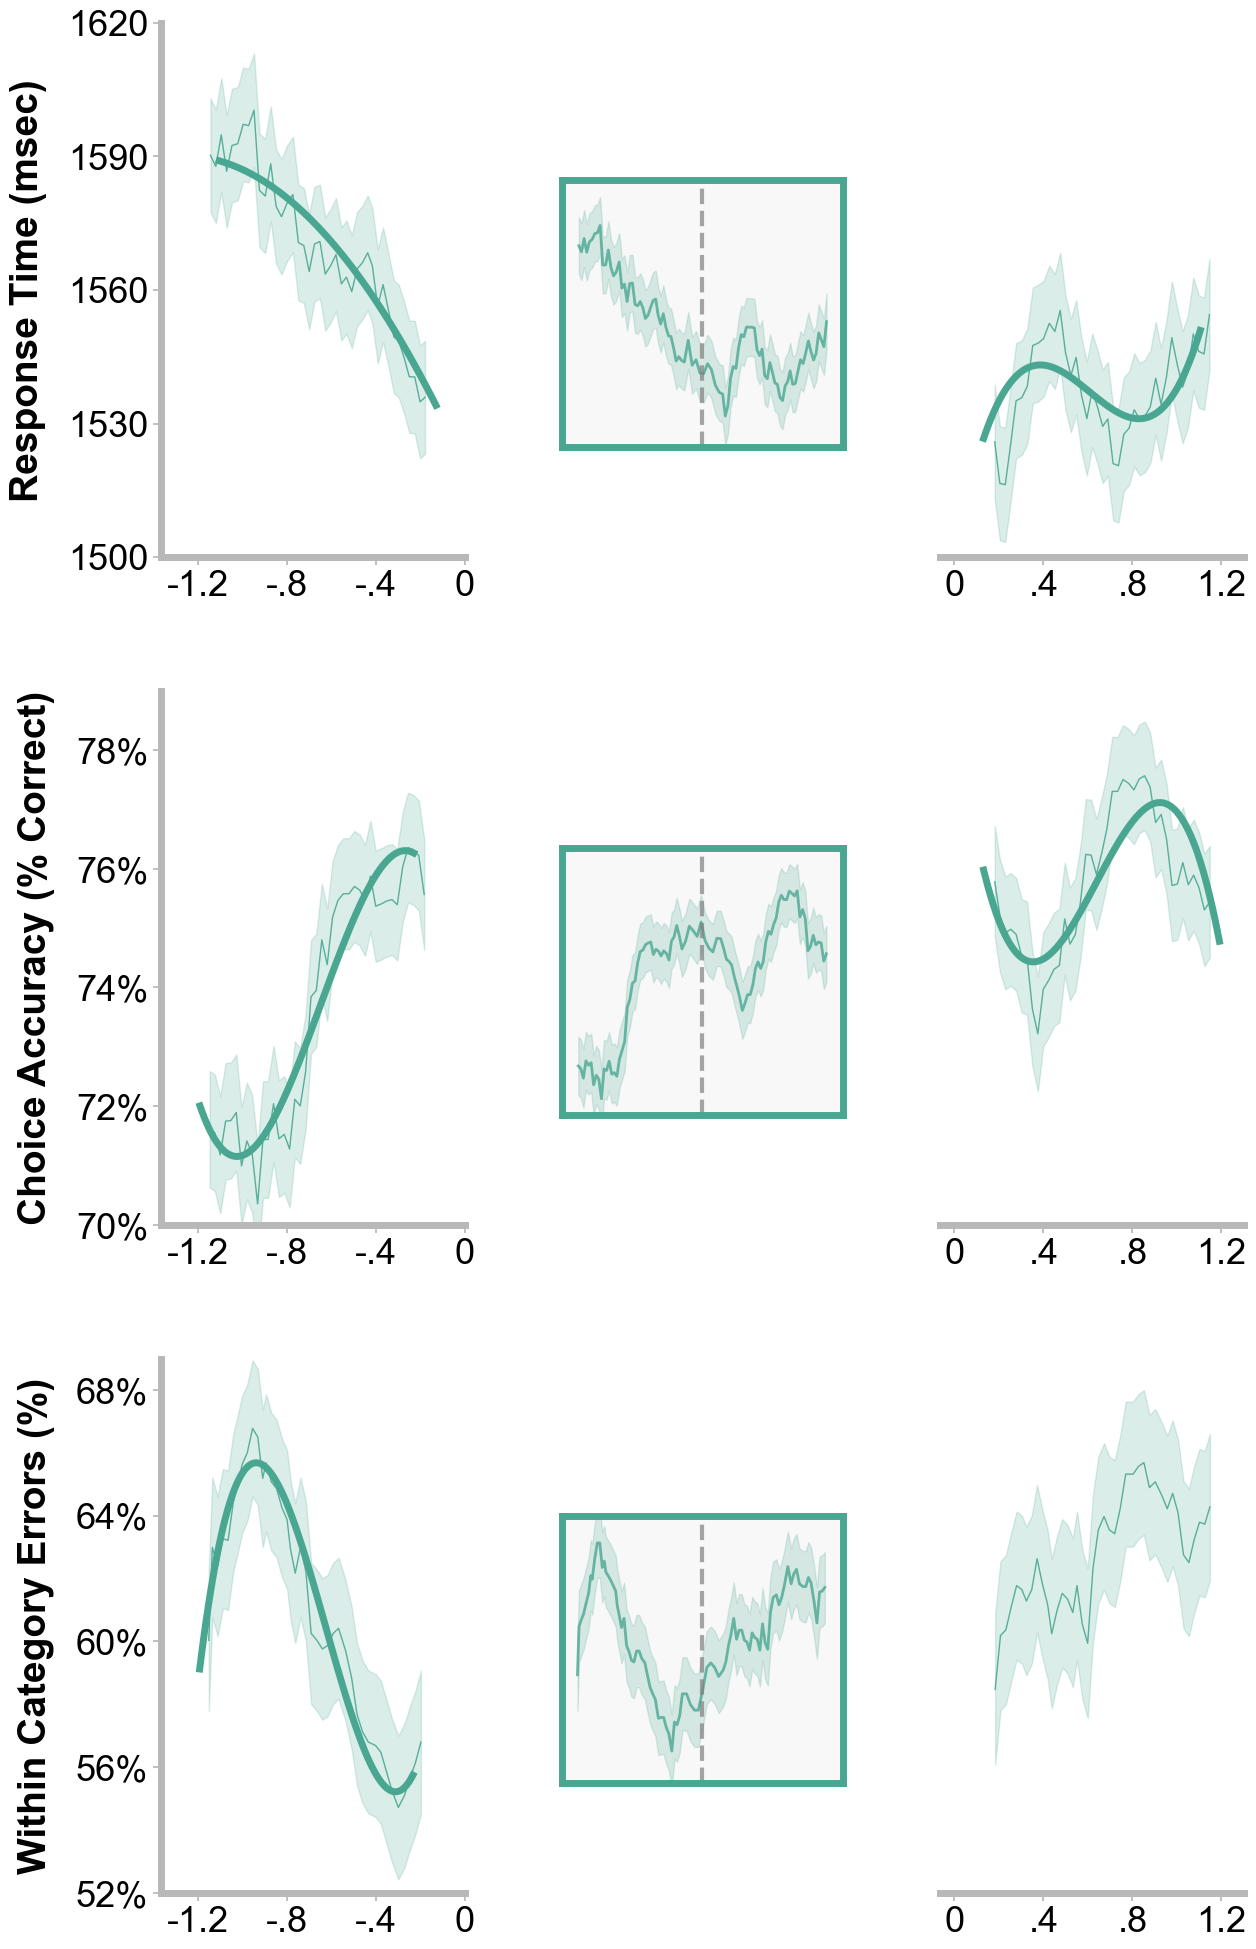

In [18]:
fig, accuracy_fits = create_three_panel_visualization(
    plot_configs_it,
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03,
    grey_out_models={2: {'right': True}},
    x_buffer_percent=0.05,
    save_accuracy_model_fits=True,  # Only save row 1 accuracy fits from continuous rolling average
    accuracy_model_fits_filename='experiment_accuracy_fits_it'
)
    # accuracy_model_fits_filename='experiment_accuracy_fits_it_pilot5'

accuracy_fits = load_accuracy_model_fits('experiment_accuracy_fits_it')
# plot_saved_accuracy_model_fits(accuracy_fits, row_indices=[1])  # Shows left extending TO x=0, right starting FROM x=0



⏭️  Row 0: Skipping - only saving row 1 (second row)
left side - All Data, Total points: 30019, Window size: 6003, Step size: 600
  📊 left side - All Data Model Fit Exclusions:
     Total points: 30019
     No trimming applied
     Excluded by rolling constraint - Left edge: 2999
     Excluded by rolling constraint - Right edge: 2970
     Points used in model fit: 24050
     Total excluded: 5969
Continuous rolling - All Data, Total points: 60219, Window size: 6021, Step size: 602
right side - All Data, Total points: 30200, Window size: 6040, Step size: 604
  📊 right side - All Data Model Fit Exclusions:
     Total points: 30200
     No trimming applied
     Excluded by rolling constraint - Left edge: 3007
     Excluded by rolling constraint - Right edge: 2990
     Points used in model fit: 24203
     Total excluded: 5997

🎯 Row 1: Extracting model fits from continuous rolling average (y_col='Accuracy')
left side - All Data, Total points: 40353, Window size: 8070, Step size: 807
  📊 le

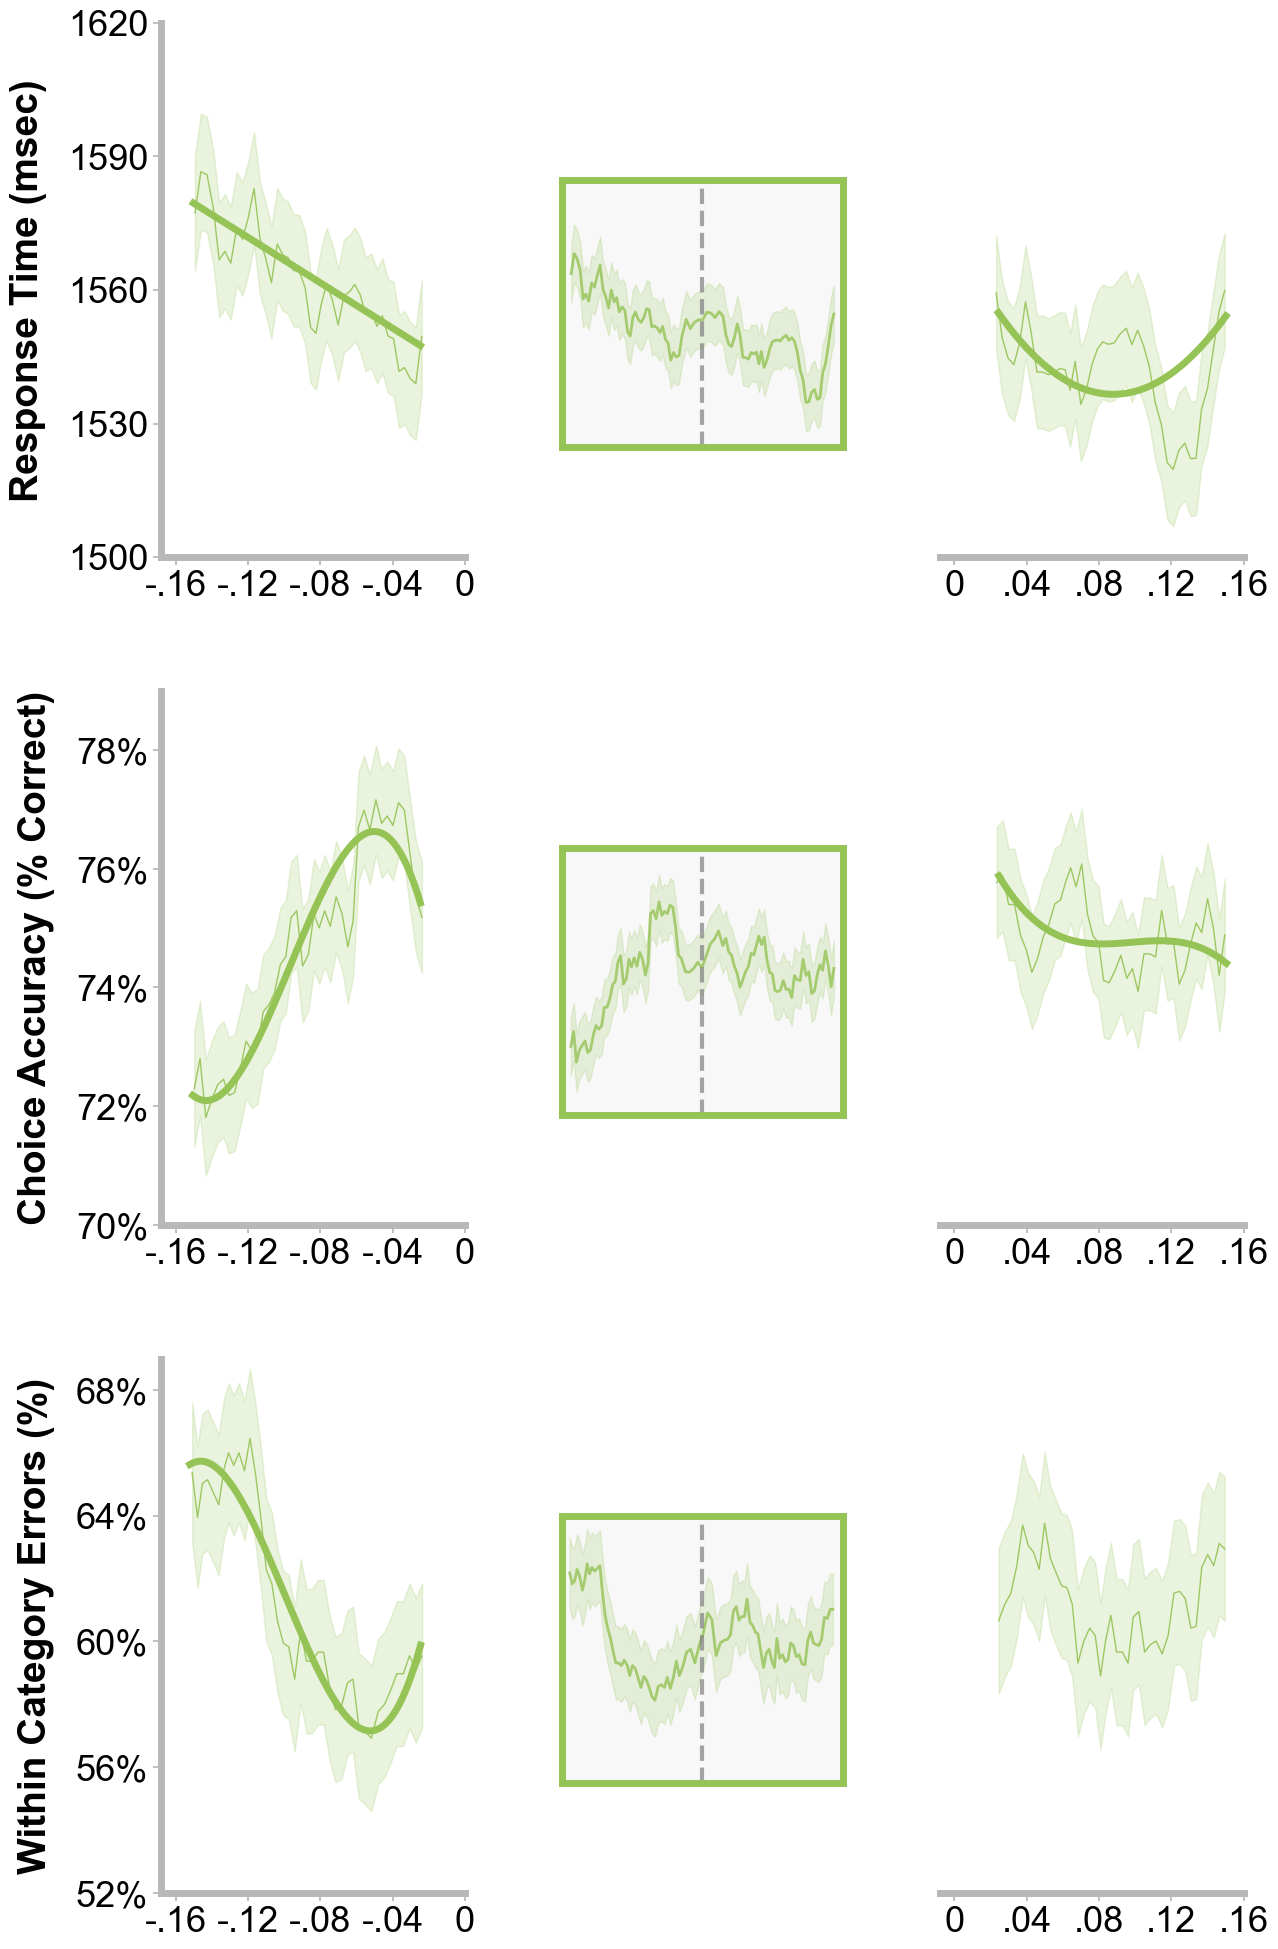

In [19]:
fig, accuracy_fits = create_three_panel_visualization(
    plot_configs_v2,
    middle_width=0.35,
    middle_height_shift=0.05,
    middle_size_scale=0.5,
    adjustable_gap=-0.03,
    grey_out_models={2: {'right': True}},
    x_buffer_percent=0.05,
    save_accuracy_model_fits=True,  # Only save row 1 accuracy fits from continuous rolling average
    accuracy_model_fits_filename='experiment_accuracy_fits_v2'
)
accuracy_fits = load_accuracy_model_fits('experiment_accuracy_fits_v2')
# plot_saved_accuracy_model_fits(accuracy_fits, row_indices=[1])  # Shows left extending TO x=0, right starting FROM x=0


In [20]:
model_fits_it = load_model_fits('experiment_accuracy_fits_it')
model_fits_v2 = load_model_fits('experiment_accuracy_fits_v2')

In [21]:
import numpy as np
import pandas as pd

def enhance_df_with_model_fit_p_values(df, model_fits_it, model_fits_v2, 
                                      it_similarity_col="Tested - Untested IT Distractor Similarity",
                                      v2_similarity_col="Tested - Untested V2 Distractor Similarity",
                                      item_col=None):
    """
    Enhance dataframe with p-values and 1-p values derived from model fits.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe to enhance
    model_fits_it : dict
        IT model fits loaded from saved files
    model_fits_v2 : dict
        V2 model fits loaded from saved files
    it_similarity_col : str
        Column name for IT similarity values
    v2_similarity_col : str
        Column name for V2 similarity values
    item_col : str, optional
        Column name for item/condition grouping (e.g., 'prioritized', 'deprioritized')
        
    Returns:
    --------
    pandas.DataFrame
        Enhanced dataframe with new columns:
        - 'it_model_p': p-values from IT model fits
        - 'it_model_1_minus_p': 1-p values from IT model fits
        - 'v2_model_p': p-values from V2 model fits
        - 'v2_model_1_minus_p': 1-p values from V2 model fits
    """
    
    # Create a copy of the input dataframe
    df_enhanced = df.copy()
    
    # Initialize new columns
    df_enhanced['it_model_p'] = np.nan
    df_enhanced['it_model_1_minus_p'] = np.nan
    df_enhanced['v2_model_p'] = np.nan
    df_enhanced['v2_model_1_minus_p'] = np.nan
    
    def get_model_prediction(x_value, model_fits_data, item_name=None):
        """
        Get model prediction for a given x-value using the appropriate side's model fit.
        
        Parameters:
        -----------
        x_value : float
            The similarity value (x-coordinate)
        model_fits_data : dict
            Model fits data structure
        item_name : str, optional
            Item/condition name for lookup
            
        Returns:
        --------
        float or np.nan
            Predicted p-value from the model
        """
        
        # Determine which side to use based on x_value
        if x_value <= 0:
            side_key = 'left_side'
        else:
            side_key = 'right_side'
        
        # Look for the appropriate model fit
        # First, try to find row_1 (which should contain accuracy data)
        if 'row_1' in model_fits_data and 'model_fits' in model_fits_data['row_1']:
            model_fits = model_fits_data['row_1']['model_fits']
            
            if side_key in model_fits:
                side_fits = model_fits[side_key]
                
                # Try to find the specific item fit
                model_key = None
                if item_name is not None:
                    # Look for exact match first
                    if item_name in side_fits:
                        model_key = item_name
                    else:
                        # Look for partial matches
                        item_lower = str(item_name).lower()
                        for key in side_fits.keys():
                            if item_lower in str(key).lower() or str(key).lower() in item_lower:
                                model_key = key
                                break
                
                # If no item-specific fit found, try 'all_data' or first available
                if model_key is None:
                    if 'all_data' in side_fits:
                        model_key = 'all_data'
                    elif len(side_fits) > 0:
                        model_key = list(side_fits.keys())[0]
                
                if model_key is not None and model_key in side_fits:
                    fit_data = side_fits[model_key]
                    
                    # Check if x_value is within the model's domain
                    x_min = fit_data.get('x_range_min', -np.inf)
                    x_max = fit_data.get('x_range_max', np.inf)
                    
                    if x_min <= x_value <= x_max:
                        # Get model coefficients and create polynomial
                        coeffs = fit_data.get('model_coefficients', [])
                        if len(coeffs) > 0:
                            poly = np.poly1d(coeffs)
                            prediction = poly(x_value)
                            
                            # Ensure prediction is within reasonable bounds for probability
                            prediction = np.clip(prediction, 0.0, 1.0)
                            
                            return prediction
        
        return np.nan
    
    # Process IT similarity values
    if it_similarity_col in df_enhanced.columns:
        print(f"Processing IT similarity values from column: {it_similarity_col}")
        
        for idx, row in df_enhanced.iterrows():
            x_value = row[it_similarity_col]
            
            if not pd.isna(x_value):
                # Get item name if available
                item_name = None
                if item_col is not None and item_col in df_enhanced.columns:
                    item_name = row[item_col]
                
                # Get model prediction
                p_value = get_model_prediction(x_value, model_fits_it, item_name)
                
                if not pd.isna(p_value):
                    df_enhanced.at[idx, 'it_model_p'] = p_value
                    df_enhanced.at[idx, 'it_model_1_minus_p'] = 1.0 - p_value
    
    # Process V2 similarity values
    if v2_similarity_col in df_enhanced.columns:
        print(f"Processing V2 similarity values from column: {v2_similarity_col}")
        
        for idx, row in df_enhanced.iterrows():
            x_value = row[v2_similarity_col]
            
            if not pd.isna(x_value):
                # Get item name if available
                item_name = None
                if item_col is not None and item_col in df_enhanced.columns:
                    item_name = row[item_col]
                
                # Get model prediction
                p_value = get_model_prediction(x_value, model_fits_v2, item_name)
                
                if not pd.isna(p_value):
                    df_enhanced.at[idx, 'v2_model_p'] = p_value
                    df_enhanced.at[idx, 'v2_model_1_minus_p'] = 1.0 - p_value
    
    # Print summary statistics
    print("\nSummary of enhanced dataframe:")
    print(f"Total rows: {len(df_enhanced)}")
    
    for col in ['it_model_p', 'it_model_1_minus_p', 'v2_model_p', 'v2_model_1_minus_p']:
        if col in df_enhanced.columns:
            valid_count = df_enhanced[col].notna().sum()
            if valid_count > 0:
                mean_val = df_enhanced[col].mean()
                min_val = df_enhanced[col].min()
                max_val = df_enhanced[col].max()
                print(f"{col}: {valid_count} valid values, mean={mean_val:.4f}, range=[{min_val:.4f}, {max_val:.4f}]")
            else:
                print(f"{col}: No valid values found")
    
    return df_enhanced


def inspect_model_fits_structure(model_fits_data, title="Model Fits"):
    """
    Helper function to inspect the structure of model fits data.
    
    Parameters:
    -----------
    model_fits_data : dict
        Model fits data to inspect
    title : str
        Title for the inspection output
    """
    
    print(f"\n=== {title} Structure ===")
    
    for row_key, row_data in model_fits_data.items():
        print(f"\n{row_key}:")
        
        if 'config' in row_data:
            config = row_data['config']
            print(f"  Config:")
            print(f"    x_col: {config.get('x_col', 'N/A')}")
            print(f"    y_col: {config.get('y_col', 'N/A')}")
            print(f"    item_col: {config.get('item_col', 'N/A')}")
        
        if 'model_fits' in row_data:
            model_fits = row_data['model_fits']
            print(f"  Model Fits:")
            
            for side_key, side_data in model_fits.items():
                print(f"    {side_key}: {len(side_data)} models")
                
                for model_key, model_info in side_data.items():
                    x_min = model_info.get('x_range_min', 'N/A')
                    x_max = model_info.get('x_range_max', 'N/A')
                    order = model_info.get('model_order', 'N/A')
                    item_name = model_info.get('item_name', 'N/A')
                    
                    print(f"      {model_key} ({item_name}): order={order}, x_range=[{x_min}, {x_max}]")


# Example usage:
def example_usage():
    """
    Example of how to use the enhancement function.
    """
    
    # Load your model fits (assuming you have these functions from your code)
    # model_fits_it = load_model_fits('experiment_accuracy_fits_it')
    # model_fits_v2 = load_model_fits('experiment_accuracy_fits_v2')
    
    # Inspect the structure first (optional)
    # inspect_model_fits_structure(model_fits_it, "IT Model Fits")
    # inspect_model_fits_structure(model_fits_v2, "V2 Model Fits")
    
    # Enhance your dataframe
    # df_enhanced = enhance_df_with_model_fit_p_values(
    #     df=your_dataframe,
    #     model_fits_it=model_fits_it,
    #     model_fits_v2=model_fits_v2,
    #     it_similarity_col="Tested - Untested IT Distractor Similarity",
    #     v2_similarity_col="Tested - Untested V2 Distractor Similarity",
    #     item_col="your_item_column_name"  # e.g., condition column with 'prioritized'/'deprioritized'
    # )
    
    # The enhanced dataframe will now have these new columns:
    # - 'it_model_p': p-values from IT model fits
    # - 'it_model_1_minus_p': 1-p values from IT model fits  
    # - 'v2_model_p': p-values from V2 model fits
    # - 'v2_model_1_minus_p': 1-p values from V2 model fits
    
    pass


if __name__ == "__main__":
    print("Model fit p-value enhancement functions loaded.")
    print("Use enhance_df_with_model_fit_p_values() to add p-values to your dataframe.")
    print("Use inspect_model_fits_structure() to examine your model fits data structure.")

df_enhanced = enhance_df_with_model_fit_p_values(
        df=df,
        model_fits_it=model_fits_it,
        model_fits_v2=model_fits_v2,
        it_similarity_col="Tested - Untested IT Distractor Similarity",
        v2_similarity_col="Tested - Untested V2 Distractor Similarity"
        # item_col="your_item_column_name"  # e.g., condition column with 'prioritized'/'deprioritized'
    )

Model fit p-value enhancement functions loaded.
Use enhance_df_with_model_fit_p_values() to add p-values to your dataframe.
Use inspect_model_fits_structure() to examine your model fits data structure.
Processing IT similarity values from column: Tested - Untested IT Distractor Similarity
Processing V2 similarity values from column: Tested - Untested V2 Distractor Similarity

Summary of enhanced dataframe:
Total rows: 80637
it_model_p: 72556 valid values, mean=0.7481, range=[0.7125, 0.7704]
it_model_1_minus_p: 72556 valid values, mean=0.2519, range=[0.2296, 0.2875]
v2_model_p: 72308 valid values, mean=0.7486, range=[0.7210, 0.7642]
v2_model_1_minus_p: 72308 valid values, mean=0.2514, range=[0.2358, 0.2790]


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FuncFormatter, MultipleLocator

def remove_leading_zero_formatter(x, pos):
    """Custom formatter to remove leading zeros from tick labels"""
    if x == 0:
        return '0'
    elif x > 0:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('0.'):
            return formatted[1:]
        return formatted
    else:
        formatted = f'{x:.2f}'.rstrip('0').rstrip('.')
        if formatted.startswith('-0.'):
            return '-' + formatted[2:]
        return formatted

def get_wm_data_type_colors():
    """Get colors for working memory analysis"""
    return {
        'IT': '#49a791',   # Teal for IT 
        'V2': '#95c355',   # Green for V2
        'grey': '#BFBFBF'  # Grey for fit lines
    }

def analyze_pvalue_bins_wm(df_enhanced, data_type='IT', pvalue_type='regular', 
                          accuracy_col='Accuracy', subject_col='participant', n_bins=3):
    """
    Analyze working memory accuracy in bins based on model fit p-values.
    """
   
    if data_type == 'IT':
        # For WM, use the non-LTM pos/neg columns
        posneg_col = 'it_pos_neg'  # Remove _ltm suffix for WM
        if pvalue_type == 'regular':
            pvalue_col = 'it_model_p'  # Use model fit p-values
        elif pvalue_type == 'flipped':
            pvalue_col = 'it_model_1_minus_p'  # Use model fit 1-p values
        else:
            raise ValueError("pvalue_type must be 'regular' or 'flipped'")
            
    elif data_type == 'V2':
        posneg_col = 'v2_pos_neg'  # Remove _ltm suffix for WM
        if pvalue_type == 'regular':
            pvalue_col = 'v2_model_p'  # Use model fit p-values
        elif pvalue_type == 'flipped':
            pvalue_col = 'v2_model_1_minus_p'  # Use model fit 1-p values
        else:
            raise ValueError("pvalue_type must be 'regular' or 'flipped'")
    else:
        raise ValueError("data_type must be 'IT' or 'V2'")
    
    # Check if required columns exist
    missing_cols = []
    for col in [pvalue_col, posneg_col, accuracy_col, subject_col]:
        if col not in df_enhanced.columns:
            missing_cols.append(col)
    
    if missing_cols:
        available_cols = [col for col in df_enhanced.columns if any(x in col for x in ['model_p', 'pos_neg', 'Accuracy', 'participant'])]
        raise ValueError(f"Missing columns: {missing_cols}. Available relevant columns: {available_cols}")
    
    # Filter out rows with missing p-values or accuracy
    df_clean = df_enhanced.dropna(subset=[pvalue_col, accuracy_col, posneg_col]).copy()
    
    # Regress out pos/neg effects from accuracy
    X = df_clean[posneg_col].values.reshape(-1, 1)
    y = df_clean[accuracy_col].values
    
    reg = LinearRegression().fit(X, y)
    predicted = reg.predict(X)
    regressed_accuracy = y - predicted + np.mean(y)  
    
    df_work = df_clean.copy()
    df_work['regressed_accuracy'] = regressed_accuracy
    
    results = []
    subjects = df_work[subject_col].unique()
    
    for subject in subjects:
        subj_data = df_work[df_work[subject_col] == subject].copy()
        
        if len(subj_data) == 0:
            continue
            
        p_min, p_max = subj_data[pvalue_col].min(), subj_data[pvalue_col].max()
        
        if p_min == p_max:  
            # If all p-values are the same, assign to middle bin
            middle_bin = (n_bins + 1) // 2
            subj_data['p_bin'] = middle_bin
        else:
            try:
                subj_data['p_bin'] = pd.qcut(subj_data[pvalue_col], q=n_bins, labels=range(1, n_bins + 1))
            except ValueError:
                bins = np.linspace(p_min, p_max, n_bins + 1)
                subj_data['p_bin'] = pd.cut(subj_data[pvalue_col], bins=bins, labels=range(1, n_bins + 1), include_lowest=True)
        
        for bin_num in range(1, n_bins + 1):
            bin_data = subj_data[subj_data['p_bin'] == bin_num]
            if len(bin_data) > 0:
                avg_regressed_acc = bin_data['regressed_accuracy'].mean()
                results.append({
                    'subject': subject,
                    'p_bin': bin_num,
                    'regressed_accuracy': avg_regressed_acc,
                    'n_trials': len(bin_data),
                    'p_bin_min': bin_data[pvalue_col].min(),
                    'p_bin_max': bin_data[pvalue_col].max()
                })
    
    return pd.DataFrame(results)

def plot_pvalue_analysis_wm(results_df, data_type='IT', pvalue_type='regular', n_bins=3, 
                           figsize=(7, 8), y_as_percentage=True):
    """
    Plot working memory p-value analysis results with enhanced styling.
    """
    
    # Get colors for working memory analysis
    colors = get_wm_data_type_colors()
    color = colors[data_type]
    
    # Create figure with specified size (narrower)
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set background color
    ax.set_facecolor('white')
    
    # Create the pointplot with enhanced styling (bigger points, heavier lines, no caps)
    sns.pointplot(data=results_df, x='p_bin', y='regressed_accuracy', 
                  errorbar='se', capsize=0, color=color, ax=ax,
                  linewidth=5, markersize=12)

    # Styling to match enhanced version
    font_family = 'Arial'
    label_font_size = 28
    tick_font_size = 26
    title_font_size = 30
    spine_color = '#B8B8B8'
    
    # X-axis label removed
    ax.set_xlabel('')
    
    if y_as_percentage:
        ax.set_ylabel('', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
        # Format y-axis as percentage
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    else:
        ax.set_ylabel('Regressed WM Accuracy', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    
    # Title removed (commented out)
    # ax.set_title(f"WM {data_type} Competition Analysis ({pvalue_type}, {n_bins} bins)", 
    #             fontfamily=font_family, fontsize=title_font_size, 
    #             fontweight='bold', color='black', pad=20)
    
    # Style the spines to match enhanced version
    for spine_name in ['top', 'right']:
        ax.spines[spine_name].set_visible(False)
    
    for spine_name in ['bottom', 'left']:
        ax.spines[spine_name].set_color(spine_color)
        ax.spines[spine_name].set_linewidth(5)
        
    if data_type == 'IT':
        ax.set_xlabel('   ', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    else:
        ax.set_xlabel('   ', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    ax.set_title("   \n   \n  \n ")

    # Style ticks to match enhanced version
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, 
                   labelcolor='black', width=2, length=6)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, 
                   labelcolor='black', width=2, length=6)
    
    # Set font family for tick labels
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    # Set x-tick labels
    ax.set_xticks(range(n_bins))
    ax.set_xticklabels([str(i+1) for i in range(n_bins)])
    #ax.set_ylim(0.72, 0.8)
    #ax.set_yticks([0.72, 0.74, 0.76,0.78, 0.8])
    # Apply custom formatter to x-axis
    #ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Remove grid
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def run_complete_wm_analysis(df_enhanced, data_type='IT', pvalue_type='regular', n_bins=3,
                            figsize=(7, 8), y_as_percentage=True):
    """
    Run complete working memory p-value analysis and create plots.
    """
    
    results = analyze_pvalue_bins_wm(
        df_enhanced=df_enhanced,
        data_type=data_type,
        pvalue_type=pvalue_type,
        accuracy_col='Accuracy',  # WM accuracy column
        subject_col='participant', 
        n_bins=n_bins
    )
    
    fig = plot_pvalue_analysis_wm(results, data_type, pvalue_type, n_bins,
                                 figsize=figsize, y_as_percentage=y_as_percentage)
    
    return results, fig

def create_wm_pvalue_scatter_plot(df_enhanced, data_type='IT', pvalue_type='regular',
                                 figsize=(7, 8), y_as_percentage=True):
    """
    Create working memory p-value scatter plot with enhanced styling.
    """
    
    if data_type == 'IT':
        posneg_col = 'it_pos_neg'
        pvalue_col = 'it_model_p' if pvalue_type == 'regular' else 'it_model_1_minus_p'
    elif data_type == 'V2':
        posneg_col = 'v2_pos_neg'  
        pvalue_col = 'v2_model_p' if pvalue_type == 'regular' else 'v2_model_1_minus_p'
    else:
        raise ValueError("data_type must be 'IT' or 'V2'")
    
    accuracy_col = 'Accuracy'
    subject_col = 'participant'
    n_bins = 10  
    
    # Filter out rows with missing data
    df_clean = df_enhanced.dropna(subset=[pvalue_col, accuracy_col, posneg_col]).copy()
    
    subject_dummies = pd.get_dummies(df_clean[subject_col], prefix='subj')
    
    X_pos_neg = df_clean[posneg_col].values.reshape(-1, 1)
    X_full = np.column_stack([X_pos_neg, subject_dummies.values])
    y = df_clean[accuracy_col].values
    
    reg = LinearRegression().fit(X_full, y)
    predicted = reg.predict(X_full)
    regressed_accuracy = y - predicted + np.mean(y)
    
    scatter_data = []
    subjects = df_clean[subject_col].unique()
    
    for subject in subjects:
        subj_mask = df_clean[subject_col] == subject
        subj_p_values = df_clean.loc[subj_mask, pvalue_col].values
        subj_regressed_acc = regressed_accuracy[subj_mask]
        
        if len(subj_p_values) == 0:
            continue
            
        p_min, p_max = subj_p_values.min(), subj_p_values.max()
        
        if p_min == p_max:
            bin_assignments = np.full(len(subj_p_values), 5)
        else:
            bin_edges = np.linspace(p_min, p_max, n_bins + 1)
            bin_assignments = np.digitize(subj_p_values, bin_edges) - 1
            bin_assignments = np.clip(bin_assignments, 0, n_bins - 1)  
        
        for bin_num in range(n_bins):
            bin_mask = bin_assignments == bin_num
            if np.any(bin_mask):
                avg_regressed_acc = subj_regressed_acc[bin_mask].mean()
                scatter_data.append({
                    'subject': subject,
                    'bin_num': bin_num + 1,  
                    'regressed_accuracy': avg_regressed_acc,
                    'data_type': data_type
                })
    
    scatter_df = pd.DataFrame(scatter_data)
    
    # Get colors for working memory analysis
    colors = get_wm_data_type_colors()
    color = colors[data_type]
    grey = colors['grey']
    
    # Create the lmplot with enhanced styling (narrower, bigger points, heavier line)
    g = sns.lmplot(data=scatter_df, 
                   x='bin_num', 
                   y='regressed_accuracy',
                   scatter_kws={'color': color, 'alpha': 0.8, 's': 100, 
                               'edgecolors': 'white', 'linewidth': 2},
                   line_kws={'color': grey, 'linewidth': 6},  # Heavier grey fit line
                   ci=95,
                   height=figsize[1], 
                   aspect=figsize[0]/figsize[1])
    
    # Styling to match enhanced version
    font_family = 'Arial'
    label_font_size = 28
    tick_font_size = 26
    title_font_size = 30
    spine_color = '#B8B8B8'
    
    # Access the main axis
    ax = g.ax
    
    # Set background color
    ax.set_facecolor('white')
    
    # X-axis label removed
    ax.set_xlabel('')
    
    if y_as_percentage:
        ax.set_ylabel('Working Memory Accuracy\n(% Correct)', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
        # Format y-axis as percentage
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y*100:.0f}%'))
    else:
        ax.set_ylabel('Working Memory Accuracy', 
                     fontfamily=font_family, fontsize=label_font_size, 
                     fontweight='bold', color='black', labelpad=15)
    
    # Title removed (commented out)
    # g.fig.suptitle(f'WM {data_type} Competition Scatter Plot ({pvalue_type})\nEach point = one subject\'s bin average', 
    #                fontfamily=font_family, fontsize=title_font_size, 
    #                fontweight='bold', color='black', y=1.02)
    
    # Style the spines to match enhanced version
    for spine_name in ['top', 'right']:
        ax.spines[spine_name].set_visible(False)
    
    for spine_name in ['bottom', 'left']:
        ax.spines[spine_name].set_color(spine_color)
        ax.spines[spine_name].set_linewidth(5)
    
    # Style ticks to match enhanced version
    ax.tick_params(axis='x', colors=spine_color, labelsize=tick_font_size, 
                   labelcolor='black', width=2, length=6)
    ax.tick_params(axis='y', colors=spine_color, labelsize=tick_font_size, 
                   labelcolor='black', width=2, length=6)
    
    # Set font family for tick labels
    for label in ax.get_xticklabels():
        label.set_fontfamily(font_family)
    for label in ax.get_yticklabels():
        label.set_fontfamily(font_family)
    
    # Set x-ticks and apply custom formatter
    ax.set_xticks(range(1, n_bins + 1))
    ax.xaxis.set_major_formatter(FuncFormatter(remove_leading_zero_formatter))
    
    # Remove default grid
    ax.grid(False)
    
    plt.tight_layout()
    plt.show()
    
    correlation = scatter_df['bin_num'].corr(scatter_df['regressed_accuracy'])
    
    return scatter_df, g.fig

def run_all_wm_analyses(df_enhanced, figsize=(10, 8), y_as_percentage=True):
    """
    Run all working memory p-value analyses (IT and V2, regular and flipped, 3 bins).
    """
    
    analyses = {}
    
    # IT analyses
    try:
        results_it, fig_it = run_complete_wm_analysis(df_enhanced, data_type='IT', 
                                                     pvalue_type='regular', n_bins=3,
                                                     figsize=figsize, y_as_percentage=y_as_percentage)
        analyses['it_regular'] = {'results': results_it, 'figure': fig_it}
    except Exception as e:
        analyses['it_regular'] = None
    
    try:
        results_it_flipped, fig_it_flipped = run_complete_wm_analysis(df_enhanced, data_type='IT', 
                                                                     pvalue_type='flipped', n_bins=3,
                                                                     figsize=figsize, y_as_percentage=y_as_percentage)
        analyses['it_flipped'] = {'results': results_it_flipped, 'figure': fig_it_flipped}
    except Exception as e:
        analyses['it_flipped'] = None
    
    # V2 analyses
    try:
        results_v2, fig_v2 = run_complete_wm_analysis(df_enhanced, data_type='V2', 
                                                     pvalue_type='regular', n_bins=3,
                                                     figsize=figsize, y_as_percentage=y_as_percentage)
        analyses['v2_regular'] = {'results': results_v2, 'figure': fig_v2}
    except Exception as e:
        analyses['v2_regular'] = None
    
    try:
        results_v2_flipped, fig_v2_flipped = run_complete_wm_analysis(df_enhanced, data_type='V2', 
                                                                     pvalue_type='flipped', n_bins=3,
                                                                     figsize=figsize, y_as_percentage=y_as_percentage)
        analyses['v2_flipped'] = {'results': results_v2_flipped, 'figure': fig_v2_flipped}
    except Exception as e:
        analyses['v2_flipped'] = None
    
    return analyses

# Example usage:
# results_it, fig_it = run_complete_wm_analysis(df_enhanced, data_type='IT', pvalue_type='regular', 
#                                              n_bins=3, figsize=(12, 8), y_as_percentage=True)
# 
# scatter_df_it, fig_scatter_it = create_wm_pvalue_scatter_plot(df_enhanced, data_type='IT', 
#                                                              pvalue_type='regular', figsize=(12, 8), 
#                                                              y_as_percentage=True)
# 
# all_analyses = run_all_wm_analyses(df_enhanced, figsize=(12, 8), y_as_percentage=True)

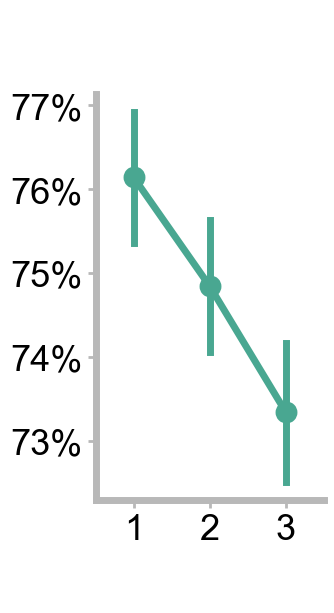

In [26]:
results_it, fig_it = run_complete_wm_analysis(df_enhanced, data_type='IT', pvalue_type='flipped', 
                                              n_bins=3, figsize=(3.5, 6.3), y_as_percentage=True)
# 

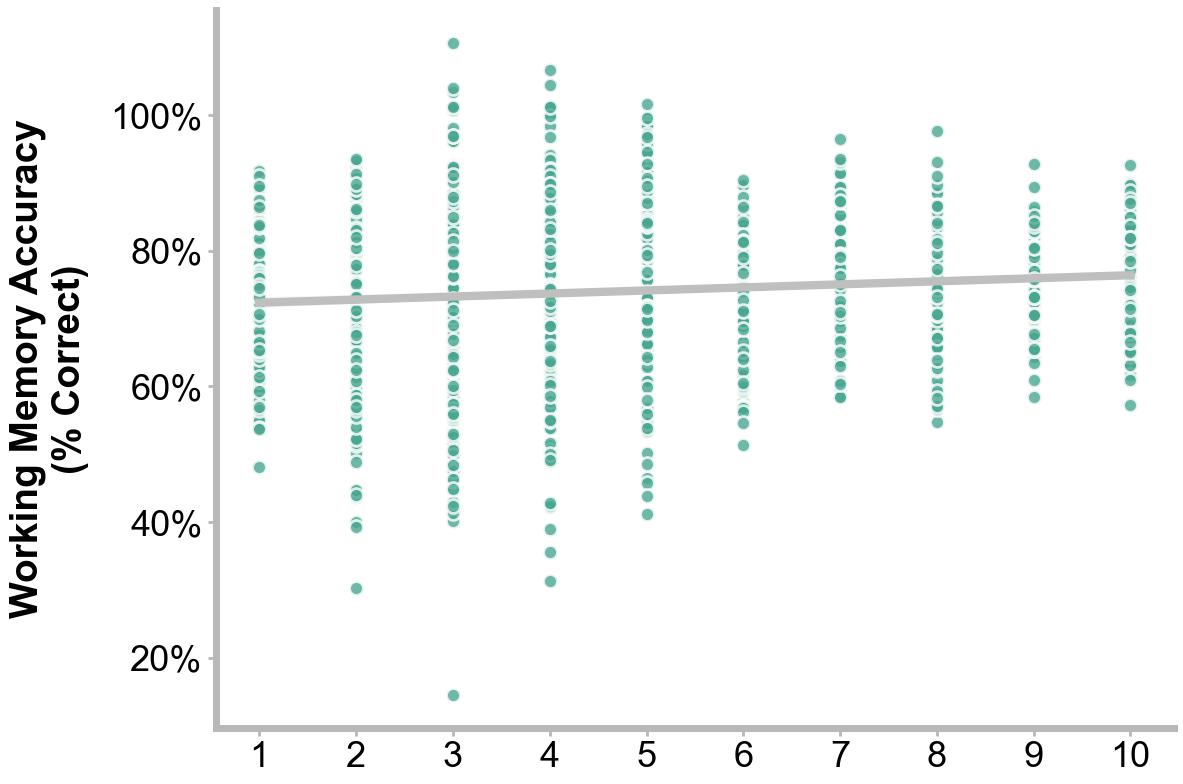

In [24]:
scatter_df_it, fig_scatter_it = create_wm_pvalue_scatter_plot(df_enhanced, data_type='IT', 
                                                              pvalue_type='regular', figsize=(12, 8), 
                                                              y_as_percentage=True)